In [1]:
!pip install xgboost
!pip install lightgbm
!pip install shap

In [2]:

import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder


In [3]:
# 2. Load two dataset
df_IMDb = pd.read_csv('19年无id有代码(9,900 imdb movies).csv') 
df_douban = pd.read_csv("douban_movies.csv")

In [4]:
# 3. Inspect both sets
df_IMDb.info()
df_douban.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9899 entries, 0 to 9898
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           9899 non-null   object 
 1   original_title  9899 non-null   object 
 2   year            9899 non-null   int64  
 3   release_date    6669 non-null   object 
 4   rating          9899 non-null   float64
 5   votes_number    9899 non-null   object 
 6   runtime         9899 non-null   int64  
 7   certificate     6742 non-null   object 
 8   countries       9899 non-null   object 
 9   genres          9899 non-null   object 
 10  plot            9899 non-null   object 
 11  director        9899 non-null   object 
 12  cast            9899 non-null   object 
 13  title_id        9899 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140502 entries, 0 to 140501
Data columns (total 21 columns):

In [5]:
# ## 4. Deal with duplicated values 处理重复值
print(df_IMDb['title_id'].duplicated().sum())      # 检查 IMDb 数据中的重复值
print(df_douban['IMDB_ID'].duplicated().sum()) 

1
27292


In [6]:
# 4.1 处理IMDBdata中的title_id的重复值

#就一个, keep first就行了
df_IMDb =df_IMDb.drop_duplicates(subset=['title_id'], keep='first')
print(df_IMDb['title_id'].duplicated().sum()) 

0


In [7]:
# IMDBdata中的id转为正常格式
df_IMDb['title_id'] = df_IMDb['title_id'].str.extract(r'(tt\d+)', expand=False)

In [8]:
#4.2 处理豆瓣中IMDB_ID中的重复值, 把重复值排到一起检查

#检查 douban 数据中的重复值都有哪些
duplicates = df_douban[df_douban.duplicated(subset=['IMDB_ID'], keep=False)]
print(duplicates[['NAME','IMDB_ID', 'YEAR','DOUBAN_VOTES']])
# 根据 release_year 列排序
duplicates_sorted = duplicates.sort_values(by='YEAR').reset_index(drop=True)

# 存储到 CSV 文件
duplicates_sorted.to_csv("duplicates_sorted_by_year.csv", index=False)

##结论是很多无意义重复, 可以都删除掉

                             NAME IMDB_ID    YEAR  DOUBAN_VOTES
0                            情定河州     NaN  2049.0           0.0
1                          我不是李小龙     NaN  2049.0           0.0
2                         曼哈顿中国女孩     NaN  2049.0           0.0
3                            绿毛水怪     NaN  2049.0           0.0
4                            为了祖国     NaN  2049.0           0.0
...                           ...     ...     ...           ...
140482      Between the Lies - 电影     NaN     0.0           0.0
140483  The Loves of Cynthia - 电影     NaN     0.0           0.0
140495             Number 15 - 电影     NaN     0.0           0.0
140497   Pretty Boy and Rosa - 电影     NaN     0.0           0.0
140498                  番茄杀手 - 电影     NaN     0.0           0.0

[27340 rows x 4 columns]


In [9]:
# 筛选出 IMDB_ID 为空且 DOUBAN_VOTES 为 0.0 的行
missing_imdb_votes_zero = df_douban[(df_douban['IMDB_ID'].isna()) & (df_douban['DOUBAN_VOTES'] == 0.0)]


# 如果需要保存结果到 CSV 文件
missing_imdb_votes_zero.to_csv("missing_imdb_votes_zero.csv", index=False)

#结论是大部分是中文电影, 可以都删除

In [10]:
# 去掉 IMDB_ID 为空的行
df_douban_non_null_imdb_id = df_douban.dropna(subset=['IMDB_ID'])

# 对 IMDB_ID 重复的记录取首值
df_douban = df_douban_non_null_imdb_id.drop_duplicates(subset=['IMDB_ID'], keep='first')


In [11]:
# 5. MERGE数据. 将 IMDb 和 Douban 数据集合并，使用 imdb_id 和 IMDB_ID 作为连接键
merged_data = pd.merge(df_IMDb, df_douban, left_on='title_id', right_on='IMDB_ID', how='inner')

# 查看合并后的数据集信息
merged_data.info()

## 此时id已无重复值, 数据精简干净但只剩7657, 后续处理还会变少

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           7657 non-null   object 
 1   original_title  7657 non-null   object 
 2   year            7657 non-null   int64  
 3   release_date    5214 non-null   object 
 4   rating          7657 non-null   float64
 5   votes_number    7657 non-null   object 
 6   runtime         7657 non-null   int64  
 7   certificate     5325 non-null   object 
 8   countries       7657 non-null   object 
 9   genres          7657 non-null   object 
 10  plot            7657 non-null   object 
 11  director        7657 non-null   object 
 12  cast            7657 non-null   object 
 13  title_id        7657 non-null   object 
 14  MOVIE_ID        7657 non-null   int64  
 15  NAME            7657 non-null   object 
 16  ALIAS           6264 non-null   object 
 17  ACTORS          7097 non-null   o

In [12]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           7657 non-null   object 
 1   original_title  7657 non-null   object 
 2   year            7657 non-null   int64  
 3   release_date    5214 non-null   object 
 4   rating          7657 non-null   float64
 5   votes_number    7657 non-null   object 
 6   runtime         7657 non-null   int64  
 7   certificate     5325 non-null   object 
 8   countries       7657 non-null   object 
 9   genres          7657 non-null   object 
 10  plot            7657 non-null   object 
 11  director        7657 non-null   object 
 12  cast            7657 non-null   object 
 13  title_id        7657 non-null   object 
 14  MOVIE_ID        7657 non-null   int64  
 15  NAME            7657 non-null   object 
 16  ALIAS           6264 non-null   object 
 17  ACTORS          7097 non-null   o

In [13]:
## 删除无用的分类变量
merged_data = merged_data.drop(columns = ['title','DOUBAN_VOTES', 'release_date','original_title','plot','title_id','ALIAS','COVER','OFFICIAL_SITE','MOVIE_ID','SLUG','REGIONS','RELEASE_DATE','STORYLINE','TAGS','ACTOR_IDS','DIRECTOR_IDS','ACTORS','DIRECTORS'])


In [14]:
merged_data.info()

#查看到很多列还不是数值型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7657 non-null   int64  
 1   rating        7657 non-null   float64
 2   votes_number  7657 non-null   object 
 3   runtime       7657 non-null   int64  
 4   certificate   5325 non-null   object 
 5   countries     7657 non-null   object 
 6   genres        7657 non-null   object 
 7   director      7657 non-null   object 
 8   cast          7657 non-null   object 
 9   NAME          7657 non-null   object 
 10  DOUBAN_SCORE  7657 non-null   float64
 11  GENRES        7657 non-null   object 
 12  IMDB_ID       7657 non-null   object 
 13  LANGUAGES     7641 non-null   object 
 14  MINS          7657 non-null   float64
 15  YEAR          7657 non-null   float64
dtypes: float64(4), int64(2), object(10)
memory usage: 957.3+ KB


In [15]:

# 初始化结果字典
result = {}

# 遍历所有列
for column in merged_data.columns:
    if merged_data[column].dtype == 'object':
        # 对于 object 类型，检查缺失值和字符串 "0"
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == '0').sum()
    else:
        # 对于数值类型，检查缺失值和数值 0
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == 0).sum()
    
    # 将结果存入字典
    result[column] = {'Missing Values': missing_count, 'Zero Values': zero_count}

# 转换为 DataFrame 格式
result_df = pd.DataFrame.from_dict(result, orient='index')

# 打印结果
print(result_df)


              Missing Values  Zero Values
year                       0            0
rating                     0            0
votes_number               0            0
runtime                    0            0
certificate             2332            0
countries                  0            0
genres                     0            0
director                   0            0
cast                       0            0
NAME                       0            0
DOUBAN_SCORE               0         2978
GENRES                     0            0
IMDB_ID                    0            0
LANGUAGES                 16            0
MINS                       0          157
YEAR                       0            1


In [16]:
# 筛选出 certificate 列缺失的电影
missing_certificate_movies = merged_data[merged_data['certificate'].isnull()]

# 查看缺失值对应的电影信息
print(missing_certificate_movies[['NAME', 'YEAR', 'IMDB_ID']])  # 根据你的数据列选择需要查看的内容


             NAME    YEAR    IMDB_ID
28    机器人总动员 - 电影  2008.0  tt0910970
31          海底总动员  2003.0  tt0266543
42     玩具总动员 - 电影  1995.0  tt0114709
44             闪灵  1980.0  tt0081505
52           虎胆龙威  1988.0  tt0095016
...           ...     ...        ...
7650         半个女友  2017.0  tt5474042
7653         杀破狼2  2015.0  tt3197766
7654    寂静之光 - 电影  2007.0  tt0841925
7655    大话西游之月光宝盒  1995.0  tt0112778
7656         油腻凶手  2016.0  tt4381236

[2332 rows x 3 columns]


In [17]:
##删除目标变量DOUBAN_SCORE的缺失值
merged_data = merged_data[merged_data['DOUBAN_SCORE'] != 0].reset_index(drop=True)
merged_data.reset_index(drop=True, inplace=True)


num_zero_douban_score = merged_data['DOUBAN_SCORE'].eq(0).sum()
print(f"Number of zero values in DOUBAN_SCORE: {num_zero_douban_score}")

Number of zero values in DOUBAN_SCORE: 0


In [18]:


# 初始化结果字典
result = {}

# 遍历所有列
for column in merged_data.columns:
    if merged_data[column].dtype == 'object':
        # 对于 object 类型，检查缺失值和字符串 "0"
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == '0').sum()
    else:
        # 对于数值类型，检查缺失值和数值 0
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == 0).sum()
    
    # 将结果存入字典
    result[column] = {'Missing Values': missing_count, 'Zero Values': zero_count}

# 转换为 DataFrame 格式
result_df = pd.DataFrame.from_dict(result, orient='index')

# 打印结果
print(result_df)


              Missing Values  Zero Values
year                       0            0
rating                     0            0
votes_number               0            0
runtime                    0            0
certificate             1341            0
countries                  0            0
genres                     0            0
director                   0            0
cast                       0            0
NAME                       0            0
DOUBAN_SCORE               0            0
GENRES                     0            0
IMDB_ID                    0            0
LANGUAGES                  9            0
MINS                       0           81
YEAR                       0            1


In [19]:
# 用 runtime 列的值插补 MINS 列中值为 0.0 的行
merged_data['MINS'] = merged_data.apply(lambda row: row['runtime'] if row['MINS'] == 0 else row['MINS'], axis=1)

# 用 year 列的值插补 YEAR 列中值为 0.0 的行
merged_data['YEAR'] = merged_data.apply(lambda row: row['year'] if row['YEAR'] == 0 else row['YEAR'], axis=1)

# 检查插补后的 MINS 和 YEAR 列
print("Updated MINS column:")
print(merged_data['MINS'].head())
print("Updated YEAR column:")
print(merged_data['YEAR'].head())


Updated MINS column:
0    139.0
1    163.0
2    195.0
3    180.0
4    113.0
Name: MINS, dtype: float64
Updated YEAR column:
0    1999.0
1    2012.0
2    1993.0
3    2013.0
4    2000.0
Name: YEAR, dtype: float64


In [20]:
# LANGUAGES 列分布百分比
languages_percentage = merged_data['LANGUAGES'].value_counts(normalize=True, dropna=False) * 100
print("Top 5 LANGUAGES Distribution (Percentage):")
print(languages_percentage.head(5))  # 显示前5个语言的分布百分比


Top 5 LANGUAGES Distribution (Percentage):
LANGUAGES
英语           63.517846
英语 / 西班牙语     2.628767
法语            2.350930
英语 / 法语       1.795255
日语            1.645651
Name: proportion, dtype: float64


In [21]:
# countries 列分布百分比
countries_percentage = merged_data['countries'].value_counts(normalize=True, dropna=False) * 100
print("Top 5 Countries Distribution (Percentage):")
print(countries_percentage.head(5))  # 显示前5个国家的分布百分比


Top 5 Countries Distribution (Percentage):
countries
['USA']          26.586878
['English']      22.611669
['India']         2.607395
['UK']            2.436418
['UK', 'USA']     1.709767
Name: proportion, dtype: float64


In [22]:
import ast

# 定义填充逻辑的函数
def impute_languages(row):
    if pd.isnull(row['LANGUAGES']):  # 检查 LANGUAGES 是否缺失
        # 解析 countries 列为列表
        try:
            countries_list = ast.literal_eval(row['countries'])  # 将字符串转换为实际列表
        except (ValueError, SyntaxError):
            countries_list = []

        # 检查是否包含指定国家
        if any(country in countries_list for country in ['USA', 'UK', 'English']):
            return 'English'  # 如果 countries 包含 'USA', 'UK', 'English'，填充为 'English'
        else:
            return 'Unknown'  # 否则填充为 'Unknown'
    return row['LANGUAGES']  # 如果 LANGUAGES 不缺失，保持原值

# 应用逻辑填充 LANGUAGES 列
merged_data['LANGUAGES'] = merged_data.apply(impute_languages, axis=1)

# 统计填充值的分布
filled_counts = merged_data['LANGUAGES'].value_counts()

# 筛选出填充值
english_filled = filled_counts.get('English', 0)  # 获取填充为 "English" 的数量
unknown_filled = filled_counts.get('Unknown', 0)  # 获取填充为 "Unknown" 的数量

# 计算总数
total_filled = english_filled + unknown_filled

# 打印结果
print(f"Total filled: {total_filled}")
print(f"Filled as 'English': {english_filled} ({english_filled / len(merged_data) * 100:.2f}%)")
print(f"Filled as 'Unknown': {unknown_filled} ({unknown_filled / len(merged_data) * 100:.2f}%)")



Total filled: 10
Filled as 'English': 7 (0.15%)
Filled as 'Unknown': 3 (0.06%)


In [23]:

# 初始化结果字典
result = {}

# 遍历所有列
for column in merged_data.columns:
    if merged_data[column].dtype == 'object':
        # 对于 object 类型，检查缺失值和字符串 "0"
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == '0').sum()
    else:
        # 对于数值类型，检查缺失值和数值 0
        missing_count = merged_data[column].isnull().sum()
        zero_count = (merged_data[column] == 0).sum()
    
    # 将结果存入字典
    result[column] = {'Missing Values': missing_count, 'Zero Values': zero_count}

# 转换为 DataFrame 格式
result_df = pd.DataFrame.from_dict(result, orient='index')

# 打印结果
print(result_df)


              Missing Values  Zero Values
year                       0            0
rating                     0            0
votes_number               0            0
runtime                    0            0
certificate             1341            0
countries                  0            0
genres                     0            0
director                   0            0
cast                       0            0
NAME                       0            0
DOUBAN_SCORE               0            0
GENRES                     0            0
IMDB_ID                    0            0
LANGUAGES                  0            0
MINS                       0            0
YEAR                       0            0


## EDA--Numeric Variables

In [24]:
# 去掉千位分隔符并转换为数值类型
merged_data['votes_number'] = merged_data['votes_number'].str.replace(',', '').astype(float)


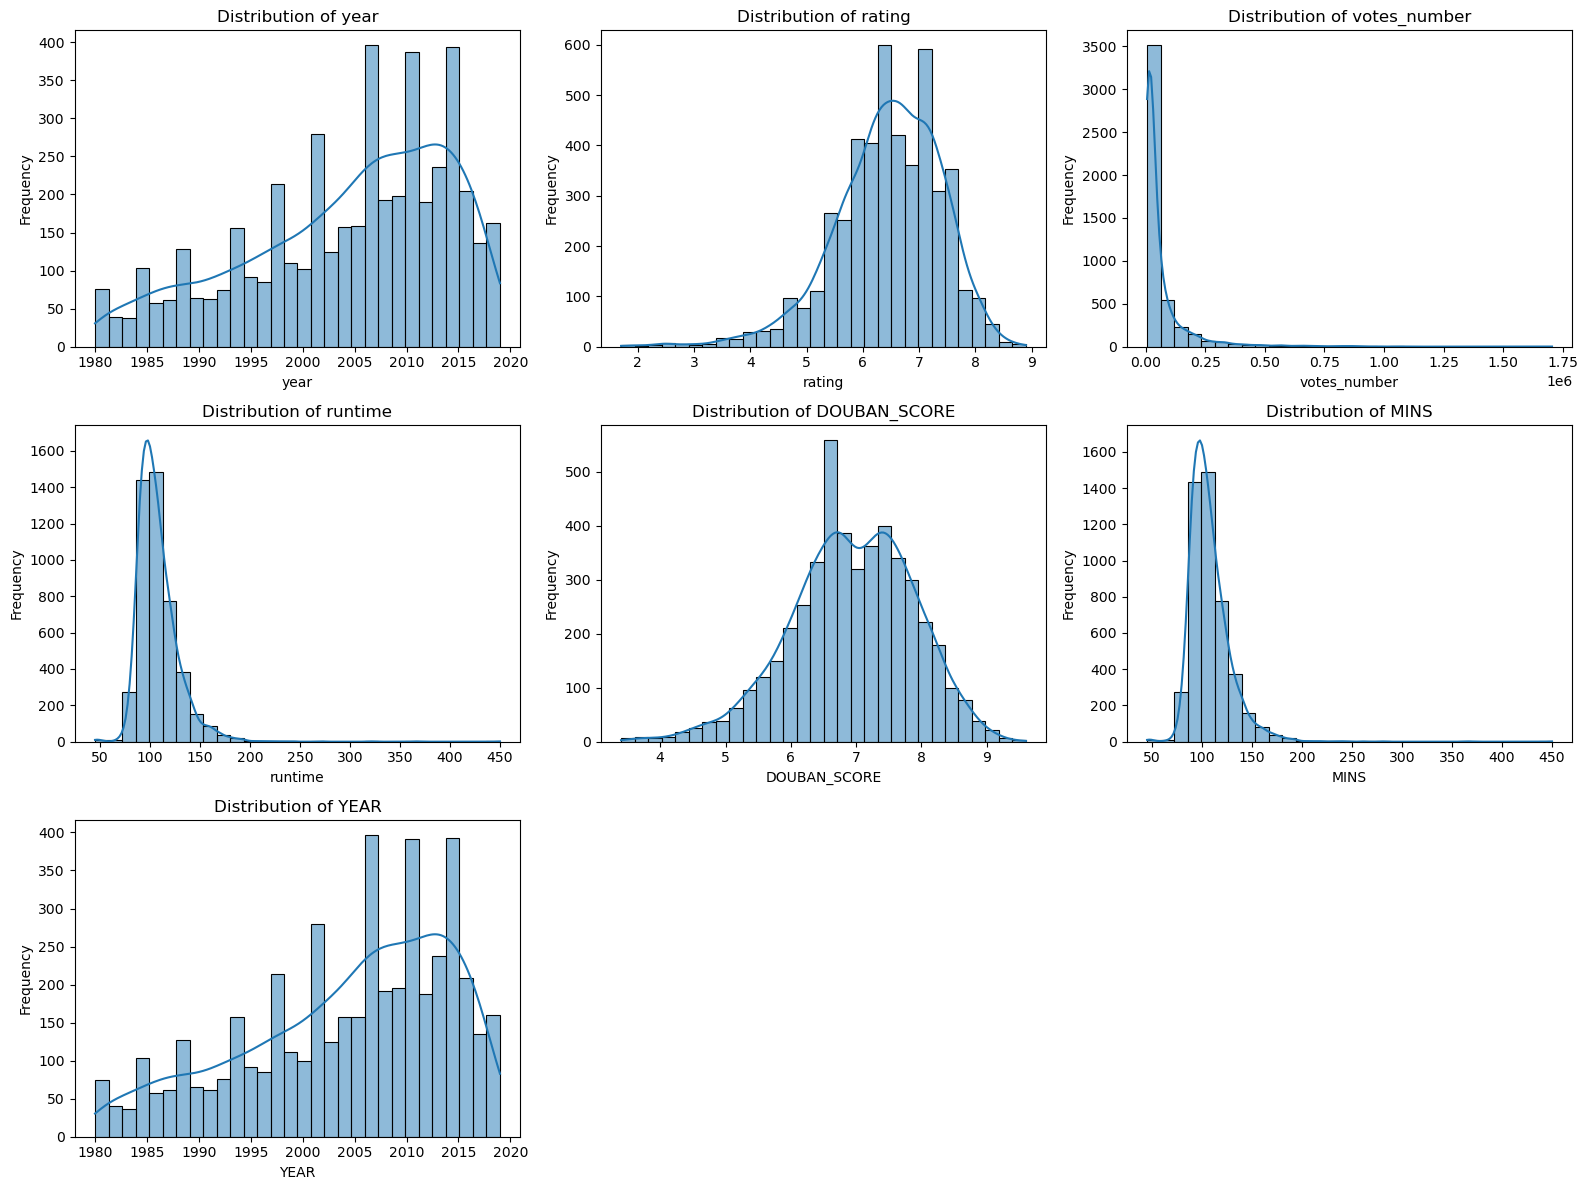

In [25]:
# 做数值型数据的分析图
# 设置图形的大小
plt.figure(figsize=(16, 12))

# 数值型列的列表
numeric_columns = ['year', 'rating', 'votes_number','runtime','DOUBAN_SCORE','MINS','YEAR']

# 对每个数值型列绘制直方图
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=merged_data, x=column, kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
output_file = "numeric_data_distribution.png"  
plt.savefig(output_file, dpi=300)
plt.show()

In [26]:
# Create standardization and normalization scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Apply logarithmic transformation and normalization to votes_number
merged_data['votes_number'] = np.log1p(merged_data['votes_number'])

# Normalize runtime and MINS using Min-Max scaling
merged_data['runtime'] = scaler_minmax.fit_transform(merged_data[['runtime']])
merged_data['MINS'] = scaler_minmax.fit_transform(merged_data[['MINS']])

# Inspect the results
print(merged_data[['votes_number', 'runtime']].head())


   votes_number   runtime
0     14.348948  0.232099
1     14.025785  0.296296
2     13.917045  0.370370
3     13.869392  0.333333
4     13.857949  0.167901


In [27]:
# 检查 year 和 YEAR 是否一致
consistency_check = merged_data['year'] == merged_data['YEAR']

# 统计不一致的数量
inconsistent_count = (~consistency_check).sum()
print(f"Number of inconsistent rows: {inconsistent_count}")


Number of inconsistent rows: 43


In [28]:
# 检查 year 和 YEAR 是否一致
consistency_check = merged_data['runtime'] == merged_data['MINS']

# 统计不一致的数量
inconsistent_count = (~consistency_check).sum()
print(f"Number of inconsistent rows: {inconsistent_count}")


Number of inconsistent rows: 635


## EDA--Non-Numeric Variables

In [29]:

translated_genres = {
    '动作': 'Action',
    '科幻': 'Sci-Fi',
    '冒险': 'Adventure',
    '惊悚': 'Thriller',
    '剧情': 'Drama',
    '喜剧': 'Comedy',
    '犯罪': 'Crime',
    '奇幻': 'Fantasy',
    '爱情': 'Romance',
    '动画': 'Animation',
    '音乐': 'Music',
    '悬疑': 'Mystery',
    '战争': 'War',
    '恐怖': 'Horror',
    '家庭': 'Family',
    '历史': 'History',
    '运动': 'Sport',
    '传记': 'Biography',
    '同性': 'LGBTQ',
    '西部': 'Western',
    '歌舞': 'Musical',
    '情色': 'Erotic',
    '武侠': 'Martial Arts',
    '古装': 'Costume Drama',
     '儿童': 'Children',
    '黑色电影': 'Film Noir',
    '灾难': 'Disaster',
    '荒诞': 'Absurd',
    '悬念': 'Suspense',
     '惊栗': 'Thriller',
    '纪录片': 'Documentary',
    '舞台艺术': 'Performing Arts',
    '鬼怪': 'Ghost'
}

# 翻译 GENRES 列并返回列表
merged_data['GENRES'] = merged_data['GENRES'].apply(
    lambda x: [translated_genres.get(genre.strip(), genre) for genre in x.split('/')] if isinstance(x, str) else []
)

# 查看结果
print(merged_data[['GENRES']].head())


                                GENRES
0   [Drama, Action, Mystery, Thriller]
1  [Drama, Action, Western, Adventure]
2                [Drama, History, War]
3    [Drama, Comedy, Biography, Crime]
4    [Drama, Mystery, Thriller, Crime]


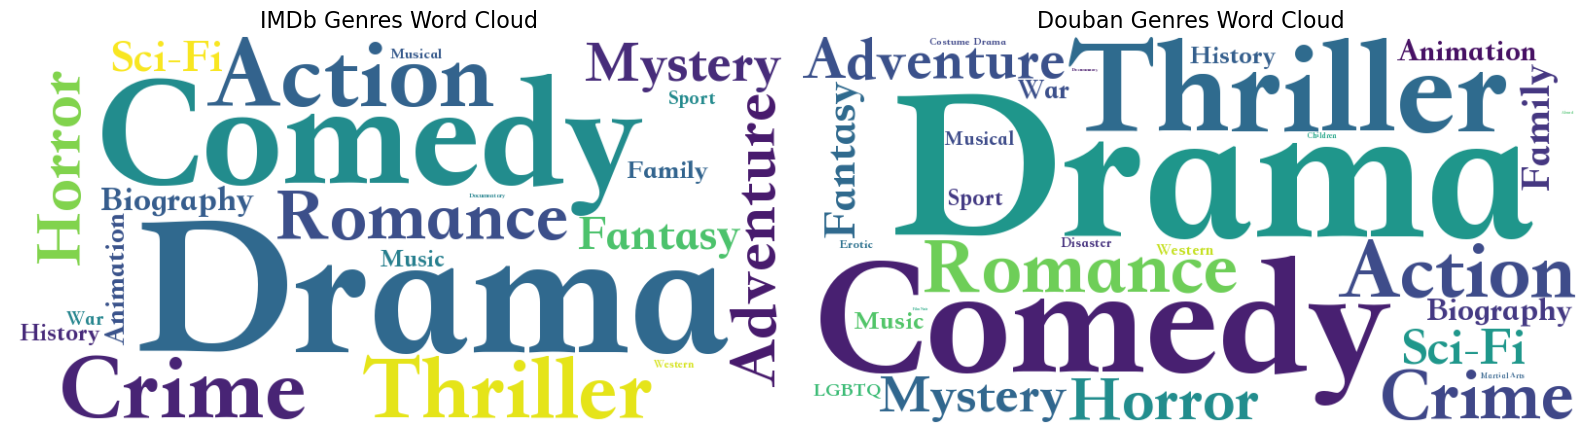

In [30]:


# 确保 genres 列解析为列表格式
def parse_genres(x):
    if isinstance(x, str):  # 如果是字符串类型
        return ast.literal_eval(x)  # 转换为 Python 列表
    return x  # 如果已经是列表，则直接返回

# 将 IMDb 和 Douban 数据解析为列表
merged_data['genres'] = merged_data['genres'].apply(parse_genres)
merged_data['GENRES'] = merged_data['GENRES'].apply(parse_genres)

# 将列表展平为单个字符串列表
imdb_genres_list = [genre.strip() for sublist in merged_data['genres'] for genre in sublist]
douban_genres_list = [genre.strip() for sublist in merged_data['GENRES'] for genre in sublist]

# 统计词频
imdb_genres_count = Counter(imdb_genres_list)
douban_genres_count = Counter(douban_genres_list)

# 创建词云
imdb_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'  
).generate_from_frequencies(imdb_genres_count)

douban_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    font_path = '/System/Library/Fonts/Supplemental/Songti.ttc'
).generate_from_frequencies(douban_genres_count)

# 绘制词云
plt.figure(figsize=(16, 8))

# IMDb 词云
plt.subplot(1, 2, 1)
plt.imshow(imdb_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('IMDb Genres Word Cloud', fontsize=16)

# 豆瓣词云
plt.subplot(1, 2, 2)
plt.imshow(douban_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Douban Genres Word Cloud', fontsize=16)

plt.tight_layout()


output_file = "Douban Genres Word Cloud.png"  
plt.savefig(output_file, dpi=300)
plt.show()

In [31]:
# 将 IMDb 和 Douban 的 genres 转换为集合
merged_data['IMDB_genres_set'] = merged_data['genres'].apply(lambda x: set(x.split('|')) if isinstance(x, str) else set())
merged_data['Douban_genres_set'] = merged_data['GENRES'].apply(lambda x: set(x) if isinstance(x, list) else set())

# 计算 Jaccard 相似度
merged_data['genres_jaccard'] = merged_data.apply(
    lambda row: len(row['IMDB_genres_set'] & row['Douban_genres_set']) / len(row['IMDB_genres_set'] | row['Douban_genres_set']) if row['IMDB_genres_set'] | row['Douban_genres_set'] else 0,
    axis=1
)

# 计算差异数量
merged_data['genres_difference_count'] = merged_data.apply(
    lambda row: len(row['IMDB_genres_set'] ^ row['Douban_genres_set']), axis=1
)

# 检查结果
print(merged_data[['genres', 'GENRES', 'genres_jaccard', 'genres_difference_count']].head(20))


                            genres                                  GENRES  \
0                          [Drama]      [Drama, Action, Mystery, Thriller]   
1                 [Drama, Western]     [Drama, Action, Western, Adventure]   
2      [Biography, Drama, History]                   [Drama, History, War]   
3        [Biography, Crime, Drama]       [Drama, Comedy, Biography, Crime]   
4              [Mystery, Thriller]       [Drama, Mystery, Thriller, Crime]   
5     [Action, Adventure, Fantasy]            [Action, Fantasy, Adventure]   
6                          [Drama]                          [Drama, Crime]   
7        [Action, Crime, Thriller]               [Action, Thriller, Crime]   
8   [Animation, Adventure, Comedy]  [Comedy, Animation, Family, Adventure]   
9      [Action, Adventure, Sci-Fi]   [Action, Sci-Fi, Thriller, Adventure]   
10    [Action, Adventure, Fantasy]             [Action, Sci-Fi, Adventure]   
11  [Animation, Adventure, Comedy]   [Drama, Comedy, Animation, 

In [32]:

# 统计频率
imdb_genres_counter = Counter(
    [genre for genres in merged_data['genres'] for genre in genres]
)

# 查看统计结果
print("IMDb Genres Frequency:")
print(imdb_genres_counter)



# Douban genres 的类别分布
douban_genre_counter = Counter([genre for genres in merged_data['GENRES'] for genre in genres])
print("\nDouban Genres Frequency:")
print(douban_genre_counter)


IMDb Genres Frequency:
Counter({'Drama': 2732, 'Comedy': 1640, 'Action': 1120, 'Crime': 999, 'Thriller': 893, 'Romance': 865, 'Horror': 675, 'Adventure': 672, 'Mystery': 482, 'Fantasy': 338, 'Sci-Fi': 318, 'Biography': 307, 'Animation': 199, 'Family': 185, 'History': 142, 'Music': 140, 'Sport': 91, 'War': 89, 'Musical': 46, 'Western': 24, 'Documentary': 3})

Douban Genres Frequency:
Counter({'Drama': 2636, 'Comedy': 1537, 'Thriller': 1434, 'Action': 1020, 'Romance': 1007, 'Crime': 905, 'Horror': 617, 'Adventure': 574, 'Mystery': 476, 'Sci-Fi': 452, 'Fantasy': 363, 'Family': 287, 'Biography': 241, 'Animation': 195, 'War': 169, 'History': 152, 'Music': 150, 'Sport': 119, 'Musical': 84, 'LGBTQ': 77, 'Western': 52, 'Disaster': 36, 'Erotic': 31, 'Costume Drama': 22, 'Martial Arts': 12, 'Children': 11, 'Documentary': 2, 'Film Noir': 1, 'Absurd': 1})


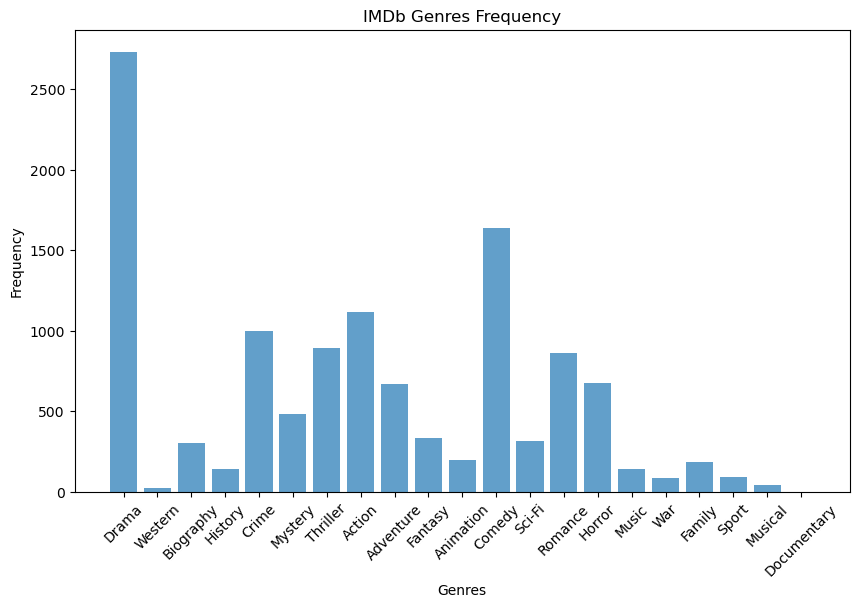

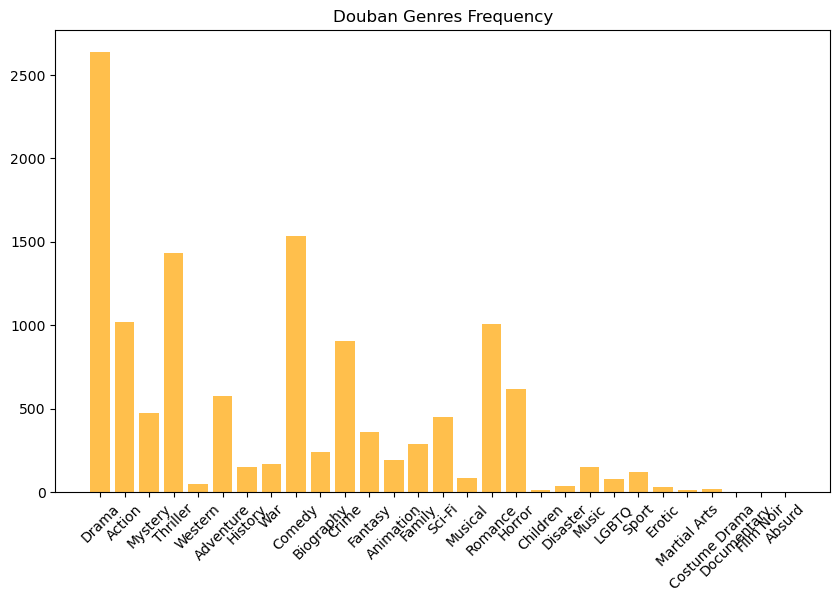

In [33]:
import matplotlib.pyplot as plt

# IMDb genres 的频率条形图
plt.figure(figsize=(10, 6))

# 确保 x 轴是完整的类别名，y 轴是对应的频率
x = list(imdb_genres_counter.keys())  # 类别名
y = list(imdb_genres_counter.values())  # 频率

# 绘制条形图
plt.bar(x, y, alpha=0.7, label="IMDb Genres")
plt.xticks(rotation=45)  # 旋转 x 轴标签
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.title("IMDb Genres Frequency")
plt.show()


# Douban genres 分布
plt.figure(figsize=(10, 6))
plt.bar(douban_genre_counter.keys(), douban_genre_counter.values(), alpha=0.7, label="Douban Genres", color='orange')
plt.xticks(rotation=45)
plt.title("Douban Genres Frequency")
plt.show()




In [34]:

# IMDb 和 Douban 的类型分布
imdb_genre_counter = Counter([genre for genres in merged_data['genres'] for genre in genres])
douban_genre_counter = Counter([genre for genres in merged_data['GENRES'] for genre in genres])

# 转换为数据框便于分析
import pandas as pd
imdb_genre_freq = pd.DataFrame(imdb_genre_counter.items(), columns=['Genre', 'IMDb_Frequency']).sort_values(by='IMDb_Frequency', ascending=False)
douban_genre_freq = pd.DataFrame(douban_genre_counter.items(), columns=['Genre', 'Douban_Frequency']).sort_values(by='Douban_Frequency', ascending=False)

# 合并两个分布表
genre_preference = (
    pd.merge(imdb_genre_freq, douban_genre_freq, on='Genre', how='outer')  # 外连接合并
    .fillna(0)  # 填充缺失值为 0
    .astype({'IMDb_Frequency': 'int', 'Douban_Frequency': 'int'})  # 确保频率列为整数类型
    .sort_values(by=['IMDb_Frequency', 'Douban_Frequency'], ascending=False)  # 按频率排序
)


# 查看类型分布差异
print(genre_preference)


            Genre  IMDb_Frequency  Douban_Frequency
0           Drama            2732              2636
1          Comedy            1640              1537
2          Action            1120              1020
3           Crime             999               905
4        Thriller             893              1434
5         Romance             865              1007
6          Horror             675               617
7       Adventure             672               574
8         Mystery             482               476
9         Fantasy             338               363
10         Sci-Fi             318               452
11      Biography             307               241
12      Animation             199               195
13         Family             185               287
14        History             142               152
15          Music             140               150
16          Sport              91               119
17            War              89               169
18        Mu

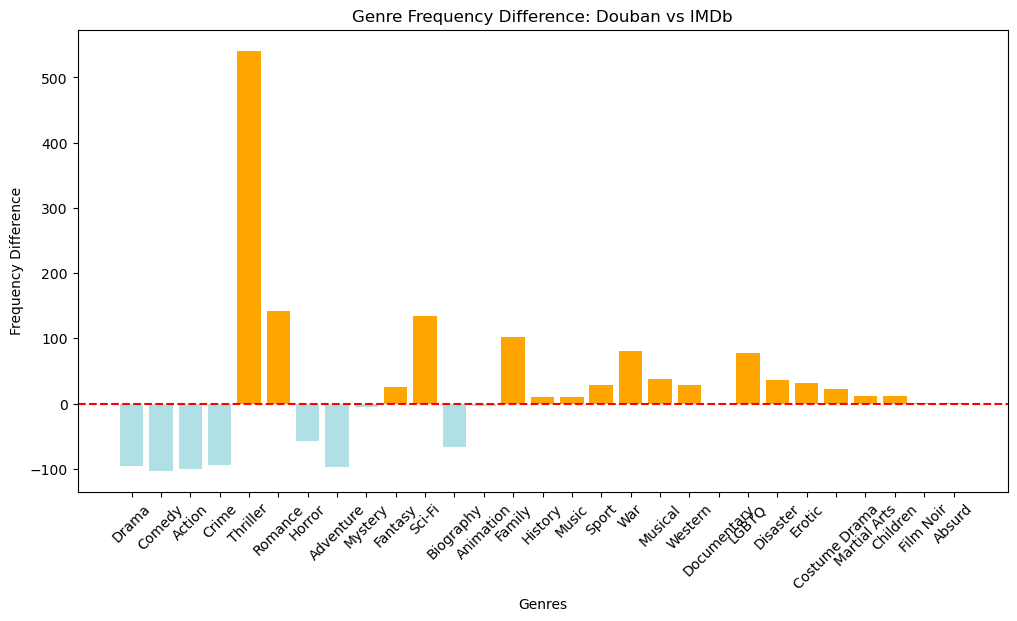

In [35]:
genre_preference['Frequency_Difference'] = genre_preference['Douban_Frequency'] - genre_preference['IMDb_Frequency']
colors = ['orange' if diff > 0 else 'powderblue' for diff in genre_preference['Frequency_Difference']]
plt.figure(figsize=(12, 6))
plt.bar(genre_preference['Genre'], genre_preference['Frequency_Difference'], color=colors)
plt.axhline(0, color='red', linestyle='--')
plt.title("Genre Frequency Difference: Douban vs IMDb")
plt.xlabel("Genres")
plt.ylabel("Frequency Difference")
plt.xticks(rotation=45)


output_file = "Frequency_Difference.png" 
plt.savefig(output_file, dpi=300)

plt.show()

In [36]:

# 手动创建一个简单的语言映射字典
language_translation = {
    '英语': 'English',
    '西班牙语': 'Spanish',
    '法语': 'French',
    '日语': 'Japanese',
    '印地语': 'Hindi',
    '印度语': 'Hindi',
    '印地语  Hindi': 'Hindi',
    '印度语 Hindi': 'Hindi',
    '德语': 'German',
    '意大利语': 'Italian',
    '韩语': 'Korean',
    '葡萄牙语': 'Portuguese',
    '阿拉伯语': 'Arabic',
    '汉语普通话': 'Mandarin',
    '粤语': 'Cantonese',
    '北印度语': 'Hindi',
    '俄语': 'Russian',
    '波斯语': 'Persian',
    '瑞典语': 'Swedish',
    '泰米尔语': 'Tamil',
    '泰卢固语': 'Telugu',
    '丹麦语': 'Danish',
    '希伯来语': 'Hebrew',
    '印尼语': 'Indonesian',
    '泰语': 'Thai',
    '荷兰语': 'Dutch',
    '无对白': 'Silent',
    '挪威语': 'Norwegian',
    '芬兰语': 'Finnish',
    '罗马尼亚语': 'Romanian',
    '匈牙利语': 'Hungarian',
    '塞尔维亚语': 'Serbian',
    '马拉雅拉姆语': 'Malayalam',
    '捷克语': 'Czech',
    '塞尔维亚-克罗地亚语': 'Serbo-Croatian',
    '吉普赛语': 'Romani',
    '菲律宾语': 'Filipino',
    '尼泊尔语': 'Nepali',
    '高棉语': 'Khmer',
    '波兰语': 'Polish',
    '加泰罗尼亚语': 'Catalan',
    '乌尔都语': 'Urdu',
    '马其顿语': 'Macedonian',
    '韩国手语': 'Korean Sign Language',
    '斯瓦希里语': 'Swahili',
    '希腊语': 'Greek',
    '印度尼西亚语': 'Indonesian',
    '印地语 Hindi': 'Hindi',
    '北印度语 Hindi': 'Hindi',
    '英語': 'English',
    '波斯语Persian': 'Persian',
    '阿拉伯语 Arabic': 'Arabic',
    '泰米尔语 Tamil':'Tamil',
    '奇楚亚语': 'Quechua',
    '巴斯克语': 'Basque',
    '马拉亚兰语': 'Malayalam',
    '美国手语': 'American Sign Language',
    '土耳其语':'Turkish',
     '塔加拉族语': 'Tagalog',
    '英国': 'English',
    '印地语 hindi': 'Hindi',
    '越南语': 'Vietnamese',
    '藏语': 'Tibetan',
    '泰米尔语 tamil': 'Tamil',
    '波斯语 Persian': 'Persian',
    '波斯尼亚语': 'Bosnian',
    '马林凯语': 'Mandinka',
    '阿拉姆语': 'Aramaic',
    '蒙古语': 'Mongolian',
    '晋语': 'Chinese',
    '印地语 HIndi': 'Hindi'
    
    # 可以根据需要添加其他语言
}

# 提取第一个语言并翻译
def translate_first_language(value):
    if isinstance(value, str):  # 仅处理字符串类型的值
        first_language = value.split(' / ')[0].strip()
        return language_translation.get(first_language, first_language)  # 翻译
    return np.nan  # 如果不是字符串，则返回 NaN

# 应用翻译函数
merged_data['LANGUAGES'] = merged_data['LANGUAGES'].apply(translate_first_language)



# 查看结果
print(merged_data[['LANGUAGES']])



      LANGUAGES
0       English
1       English
2       English
3       English
4       English
...         ...
4674    English
4675    English
4676   Mandarin
4677  Cantonese
4678    English

[4679 rows x 1 columns]


In [37]:
import re

# 使用正则表达式找出包含中文字符的行
# 中文字符的范围是 \u4e00-\u9fff
chinese_languages = merged_data[merged_data['LANGUAGES'].str.contains(r'[\u4e00-\u9fff]', na=False)]

# 打印包含中文的行
print("包含中文的项：")
print(chinese_languages[['LANGUAGES']])


包含中文的项：
Empty DataFrame
Columns: [LANGUAGES]
Index: []


In [38]:
print(merged_data['LANGUAGES'].unique())

['English' 'Japanese' 'American Sign Language' 'Aramaic' 'Cantonese'
 'German' 'Indonesian' 'Mandarin' 'Spanish' 'Hindi' 'French' 'Korean'
 'Quechua' 'Norwegian' 'Portuguese' 'Danish' 'Dutch' 'Thai' 'Telugu'
 'Swedish' 'Korean Sign Language' 'Persian' 'Serbian' 'Russian'
 'Mongolian' 'Turkish' 'Polish' 'Silent' 'Bosnian' 'Italian' 'Bhojpuri'
 'Malayalam' 'Nepali' 'Tamil' 'Arabic' 'Filipino' 'Finnish' 'Hungarian'
 'Macedonian' 'Unknown' 'Hebrew' 'Swahili' 'Romanian' 'Khmer' 'Mandinka'
 'Czech' 'Urdu' 'Greek' 'Icelandic' 'Chinese' 'Vietnamese' 'Tibetan'
 'Basque' 'Tagalog' 'Serbo-Croatian' 'Romani' 'Catalan']


In [39]:
# 定义更新后的合并映射
merge_mapping = {
    'Mandarin': 'Chinese',
    'Cantonese': 'Chinese',
    'Catalan': 'Spanish',
    'Serbian': 'Serbo-Croatian',
    'Serbo-Croatian': 'Serbo-Croatian',
}

# 替换数据
merged_data['LANGUAGES'] = merged_data['LANGUAGES'].replace(merge_mapping)

# 查看合并后的值分布
print(merged_data['LANGUAGES'].value_counts())


LANGUAGES
English                   3807
French                     175
Hindi                      164
Japanese                    89
Chinese                     79
Spanish                     74
German                      38
Korean                      35
Italian                     34
Danish                      22
Russian                     18
Persian                     15
Tamil                       12
Swedish                     12
Telugu                      10
Arabic                       9
Portuguese                   8
Turkish                      6
Thai                         6
Serbo-Croatian               6
Silent                       5
Romanian                     4
Norwegian                    4
Dutch                        4
Hungarian                    4
Finnish                      4
Unknown                      3
Malayalam                    3
Czech                        2
Hebrew                       2
Bosnian                      2
Indonesian                   

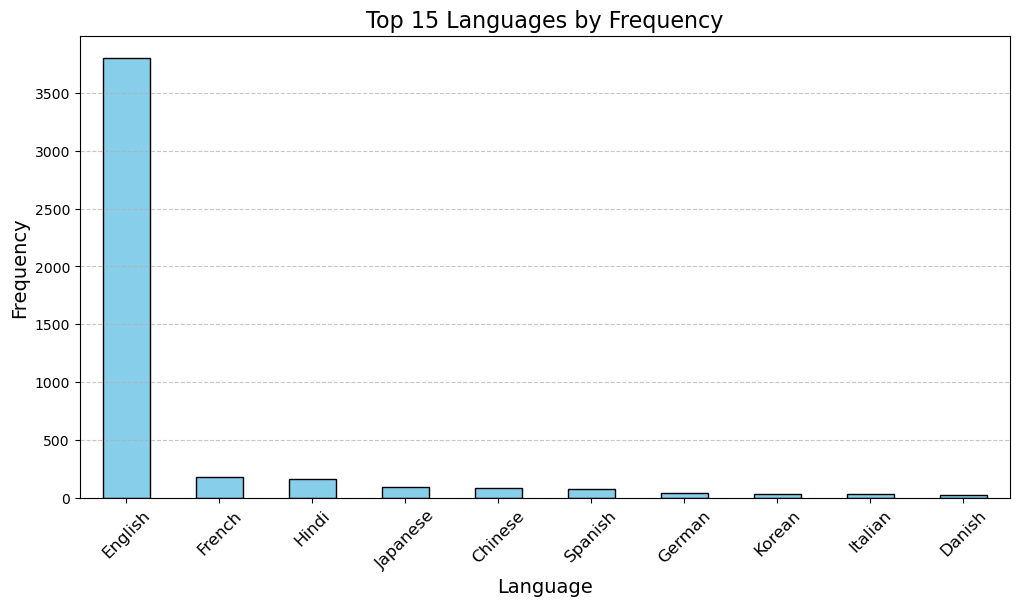

In [40]:
language_counts = merged_data['LANGUAGES'].value_counts()

plt.figure(figsize=(12, 6))
language_counts.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 15 Languages by Frequency', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# 定义清洗函数，将字符串形式的列表转换成单一国家的字符串格式
def clean_country(value):
    try:
        # 如果值是字符串形式的列表（例如："['USA', 'Canada']"），先转换为列表
        value = ast.literal_eval(value)
        # 如果转换成功且是一个列表，取第一个国家
        if isinstance(value, list):
            return str(value[0]).strip()
    except (ValueError, SyntaxError):
        # 如果转换失败，则直接检查是否是字符串，去除空格返回
        if isinstance(value, str):
            return value.strip()
    # 其他情况返回 NaN
    return np.nan

# 应用清洗函数到 countries 列
merged_data['countries'] = merged_data['countries'].apply(clean_country)

# 查看处理后的结果
print(merged_data[['countries']].head())


  countries
0       USA
1       USA
2       USA
3       USA
4       USA


In [42]:
print(merged_data['countries'].unique())


['USA' 'UK' 'Australia' 'Germany' 'English' 'Japan' 'Ireland' 'Spain'
 'France' 'Canada' 'Hong Kong' 'Aramaic' 'Japanese' 'South Africa' 'China'
 'Indonesia' 'Italy' 'Denmark' 'Arabic' 'New Zealand' 'India'
 'South Korea' 'Malta' 'Spanish' 'Norway' 'Austria' 'Mexico' 'Russia'
 'French' 'Brazil' 'Dari' 'United Arab Emirates' 'Danish' 'Netherlands'
 'Hindi' 'Thailand' 'Sweden' 'German' 'Korean' 'Iran' 'Serbian' 'Belgium'
 'Swedish' 'Cantonese' 'Gujarati' 'Poland' 'Hungary' 'Turkey'
 'Czech Republic' 'Switzerland' 'Thai' 'Dutch' 'Mandarin' 'Kenya'
 'Malayalam' 'Tamil' 'Chile' 'Palestine' 'Italian' 'Russian' 'Persian'
 'None' 'Finland' 'Saudi Arabia' 'See more' 'Israel' 'Argentina'
 'Portuguese' 'Marathi' 'Mauritania' 'Taiwan' 'Telugu' 'Panama'
 'Republic of Macedonia' 'Romanian' 'Serbia' 'Khmer' 'Turkish' 'Romania'
 'Czech' 'Soviet Union' 'Scanian' 'Bahamas' 'Icelandic' 'Afghanistan'
 'Finnish' 'Vietnamese' 'Bulgaria' 'Colombia' 'Basque'
 'Bosnia and Herzegovina' 'Hebrew']


In [43]:
# 定义需要合并的映射关系
merge_mapping = {
    'Mandarin': 'China',
    'Hong Kong': 'China',
    'Taiwan':'China',
    'Cantonese':'China',
    'Hindi': 'India',
    'India': 'India',
    'Dutch':'Netherlands',
    'Thai':'Thailand',
    'Turkish':'Turkey'
}

# 替换数据
merged_data['countries'] = merged_data['countries'].replace(merge_mapping)

# 查看合并后的值分布
print(merged_data['countries'].value_counts())

countries
USA             1648
English         1430
UK               344
India            195
France           185
                ... 
Kenya              1
Malayalam          1
Saudi Arabia       1
Palestine          1
Khmer              1
Name: count, Length: 84, dtype: int64


In [44]:
import numpy as np

# 计算目标国家的频次和总频次
target_countries = ['USA', 'UK', 'Canada', 'Australia', 'Ireland']
country_counts = merged_data['countries'].value_counts()
target_counts = country_counts[target_countries]

# 计算比例
total_target_count = target_counts.sum()
target_ratios = target_counts / total_target_count

# 获取 'English' 的索引
english_indices = merged_data[merged_data['countries'] == 'English'].index

# 使用计算的比例进行随机分配
np.random.seed(42)  # 设置随机种子，保证结果可重复
assignments = np.random.choice(
    target_countries, 
    size=len(english_indices), 
    p=target_ratios.values
)

# 更新 'countries' 列
merged_data.loc[english_indices, 'countries'] = assignments

# 查看更新后的分布
print(merged_data['countries'].value_counts())


countries
USA             2734
UK               575
India            195
France           185
Canada           125
                ... 
Kenya              1
Malayalam          1
Saudi Arabia       1
Palestine          1
Khmer              1
Name: count, Length: 83, dtype: int64


## Pre-split Encoding

## frequency encoding--certificate, country, language


In [45]:
# 将缺失值替换为 'Missing'
merged_data['certificate'] = merged_data['certificate'].fillna('Missing')

# 检查更新后的 certificate 列
print(merged_data['certificate'].value_counts())

# 计算 certificate 列中每个唯一值的频数，包括缺失值
certificate_distribution = merged_data['certificate'].value_counts(dropna=False)

# 将分布结果显示为表格
print(certificate_distribution)


certificate
R            1846
Missing      1341
PG-13         987
PG            342
15             46
12             46
18             28
G              12
NC-17           9
16              8
7               7
b.o.            3
Not Rated       2
(Banned)        1
Unrated         1
Name: count, dtype: int64
certificate
R            1846
Missing      1341
PG-13         987
PG            342
15             46
12             46
18             28
G              12
NC-17           9
16              8
7               7
b.o.            3
Not Rated       2
(Banned)        1
Unrated         1
Name: count, dtype: int64


In [46]:
# 计算训练集中每个 certificate 类别的频数
certificate_counts = merged_data['certificate'].value_counts()

# 计算第一四分位数（Q3）
q3_threshold = certificate_counts.quantile(0.75)

# 找出低频类别（频数低于 Q3 的类别）
rare_certificates = certificate_counts[certificate_counts < q3_threshold].index.tolist()
print(f"Rare certificates in merged data: {rare_certificates}")

# 在训练集上将低频类别替换为“Other”
merged_data['certificate'] = merged_data['certificate'].replace(rare_certificates, 'Other')

# 检查最终类别分布
print("Merged data certificate distribution:")
print(merged_data['certificate'].value_counts())



Rare certificates in merged data: ['15', '12', '18', 'G', 'NC-17', '16', '7', 'b.o.', 'Not Rated', '(Banned)', 'Unrated']
Merged data certificate distribution:
certificate
R          1846
Missing    1341
PG-13       987
PG          342
Other       163
Name: count, dtype: int64


In [47]:
# 选择频次较少的类别合并为 'Other'
certificate_counts = merged_data['certificate'].value_counts()
low_freq_certificates = certificate_counts[certificate_counts < 100]  # 假设低于 100 次的类别需要合并
merged_data['certificate'] = merged_data['certificate'].apply(
    lambda x: 'Other' if x in low_freq_certificates.index else x
)

# 查看合并后的分布
print(merged_data['certificate'].value_counts())


certificate
R          1846
Missing    1341
PG-13       987
PG          342
Other       163
Name: count, dtype: int64


In [48]:
# 计算类别频率
certificate_counts = merged_data['certificate'].value_counts()

# 频次编码
merged_data['certificate_freq_encoded'] = merged_data['certificate'].map(certificate_counts)

# 处理 NaN 值，将 NaN 替换为 0 或 'Missing'
merged_data['certificate_freq_encoded'] = merged_data['certificate_freq_encoded'].fillna(0).astype(int)

# 查看结果
print(merged_data[['certificate', 'certificate_freq_encoded']].head())


  certificate  certificate_freq_encoded
0           R                      1846
1           R                      1846
2           R                      1846
3       Other                       163
4           R                      1846


  countries countries_frequency  countries_frequency_encoded
0       USA                 USA                       2734.0
1       USA                 USA                       2734.0
2       USA                 USA                       2734.0
3       USA                 USA                       2734.0
4       USA                 USA                       2734.0
countries_frequency_encoded
2734.0    2734
575.0      575
195.0      195
185.0      185
125.0      125
Name: count, dtype: int64


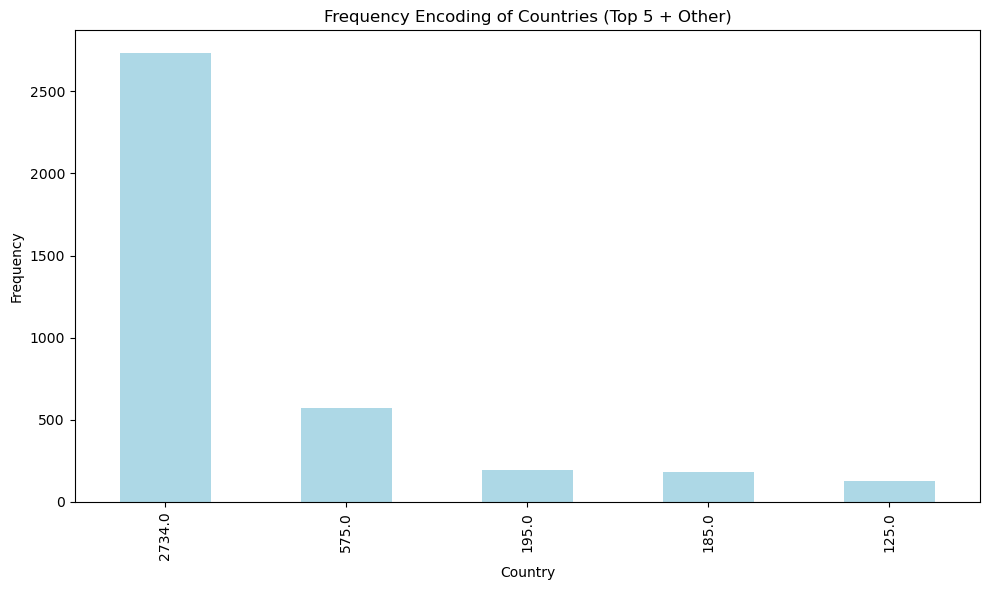

In [49]:
# 计算每个国家的频次
country_counts = merged_data['countries'].value_counts()

# 选择频数最多的前 5 个国家
top_countries = country_counts.head(5).index.tolist()

# 将其他国家归为 'Other'
merged_data['countries_frequency'] = merged_data['countries'].apply(
    lambda x: x if x in top_countries else 'Other'
)

# 计算频次编码（即国家的出现次数）
country_frequency_encoding = merged_data['countries_frequency'].map(country_counts)

# 将频次编码赋值到新的列
merged_data['countries_frequency_encoded'] = country_frequency_encoding

# 查看频次编码后的数据
print(merged_data[['countries', 'countries_frequency', 'countries_frequency_encoded']].head())

# 查看频次编码后的国家分布
print(merged_data['countries_frequency_encoded'].value_counts())

# 绘制频次编码后的分布图
plt.figure(figsize=(10, 6))
merged_data['countries_frequency_encoded'].value_counts().plot(kind='bar', color='lightblue')

# 添加标题和标签
plt.title('Frequency Encoding of Countries (Top 5 + Other)')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

# 显示图形
plt.tight_layout()
plt.show()


In [50]:

# 计算 'LANGUAGES' 列中 'English' 的占比
total_count = merged_data['LANGUAGES'].notna().sum()  # 总非空记录数
english_count = merged_data['LANGUAGES'].str.contains('English', case=False, na=False).sum()  # 'English' 的出现次数

# 计算占比百分比
english_ratio = english_count / total_count * 100
print(f"英语的占比: {english_ratio:.2f}%")


英语的占比: 81.36%


In [51]:

merged_data['is_english'] = merged_data['LANGUAGES'].apply(lambda x: 1 if 'English' in str(x) else 0)

print(merged_data[['LANGUAGES', 'is_english']].head())



  LANGUAGES  is_english
0   English           1
1   English           1
2   English           1
3   English           1
4   English           1


In [52]:
#6. 拆分数据
train_data, test_data = train_test_split(merged_data, test_size = 0.2, random_state = 42)

In [53]:
## 该编码方式比较繁琐, 最后使用树模型的话就不用它了
# 查看每个 certificate 类别的 DOUBAN_SCORE 均值
mean_douban_score_by_certificate = train_data.groupby('certificate')['DOUBAN_SCORE'].mean()
print(mean_douban_score_by_certificate)

from scipy.stats import f_oneway

# 将 DOUBAN_SCORE 按 certificate 分组
groups = [train_data[train_data['certificate'] == category]['DOUBAN_SCORE'] for category in train_data['certificate'].unique()]

# 进行方差分析
anova_result = f_oneway(*groups)
print("ANOVA test result:", anova_result)

from sklearn.preprocessing import LabelEncoder
import numpy as np

# 对 certificate 列进行 Label Encoding
label_encoder = LabelEncoder()
train_data['certificate_encoded'] = label_encoder.fit_transform(train_data['certificate'])

# 计算与 DOUBAN_SCORE 的相关系数
correlation = np.corrcoef(train_data['certificate_encoded'], train_data['DOUBAN_SCORE'])[0, 1]
print("Correlation between certificate and DOUBAN_SCORE:", correlation)


#缺失相关, 所以得用目标编码

certificate
Missing    7.048052
Other      7.079508
PG         7.313091
PG-13      6.878680
R          6.783378
Name: DOUBAN_SCORE, dtype: float64
ANOVA test result: F_onewayResult(statistic=26.56584261605099, pvalue=9.302621142643714e-22)
Correlation between certificate and DOUBAN_SCORE: -0.12557916269642272


In [54]:
# 计算每个 certificate 类别的 DOUBAN_SCORE 均值和样本数量
certificate_stats = train_data.groupby('certificate')['DOUBAN_SCORE'].agg(['mean', 'count'])

# 计算全局均值
global_mean = train_data['DOUBAN_SCORE'].mean()

# 设置平滑因子（10不太合适, 50和100之后依然变化不大, 所以最后决定50）
smoothing_factor = 50

# 计算平滑编码
certificate_stats['smoothed_mean'] = (
    certificate_stats['mean'] * certificate_stats['count'] + global_mean * smoothing_factor
) / (certificate_stats['count'] + smoothing_factor)

# 将平滑编码映射应用到训练集和测试集
certificate_encoding_map = certificate_stats['smoothed_mean'].to_dict()
train_data['certificate_encoded'] = train_data['certificate'].map(certificate_encoding_map)
test_data['certificate_encoded'] = test_data['certificate'].map(certificate_encoding_map)

# 查看 certificate 各类别在平滑编码后的值
print(certificate_encoding_map)

{'Missing': 7.04274110727732, 'Other': 7.03553470353963, 'PG': 7.253882981565589, 'PG-13': 6.88163719452126, 'R': 6.788112398044978}


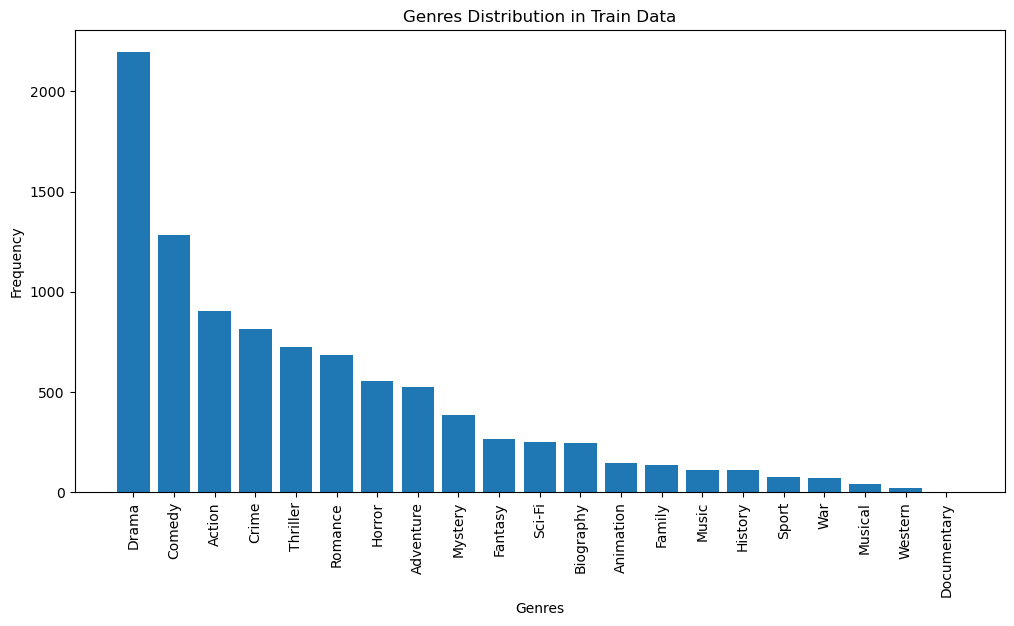

In [55]:

# 确保 'genres' 列为列表格式并转换为字符串
train_data['genres'] = train_data['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# 展开嵌套列表
all_genres = train_data['genres'].explode()

# 创建 genres 的分布统计
genre_counts = Counter(all_genres)

# 转换为 DataFrame 以便可视化
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)

# 可视化 genres 分布
plt.figure(figsize=(12, 6))
plt.bar(genre_df.index, genre_df['count'])
plt.xticks(rotation=90)
plt.title('Genres Distribution in Train Data')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.show()


                              count
Comedy, Drama, Romance          185
Drama                           178
Comedy, Drama                   161
Drama, Romance                  154
Action, Crime, Drama            131
Comedy, Romance                 102
Crime, Drama, Thriller           86
Horror, Thriller                 71
Action, Comedy, Crime            70
Crime, Drama, Mystery            67
Horror, Mystery, Thriller        66
Action, Adventure, Comedy        64
Drama, Thriller                  63
Action, Crime, Thriller          59
Horror                           58
Adventure, Animation, Comedy     58
Comedy                           56
Crime, Drama                     53
Comedy, Crime, Drama             53
Action, Adventure, Sci-Fi        46


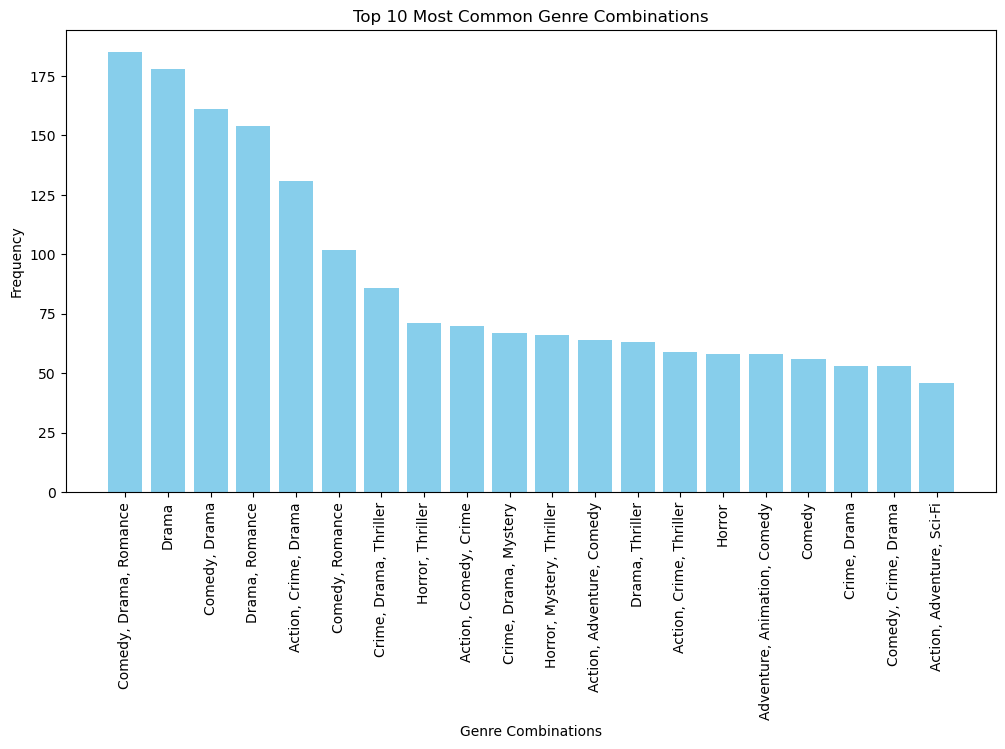

In [56]:
from collections import Counter

# 将 genres 列表转换为字符串表示，以便统计组合
train_data['genres_combination'] = train_data['genres'].apply(lambda x: ', '.join(sorted(x)))

# 统计每种组合的出现频率
combination_counts = Counter(train_data['genres_combination'])

# 将结果转换为 DataFrame 并排序
combination_df = pd.DataFrame.from_dict(combination_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)

# 显示出现次数最多的前 10 种组合
top_combinations = combination_df.head(20)
print(top_combinations)

# 可视化前 10 种组合
plt.figure(figsize=(12, 6))
plt.bar(top_combinations.index, top_combinations['count'], color='skyblue')
plt.xticks(rotation=90)
plt.title('Top 10 Most Common Genre Combinations')
plt.xlabel('Genre Combinations')
plt.ylabel('Frequency')
plt.show()


/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


genre_cluster
3    1306
2    1088
1     897
0     452
Name: count, dtype: int64


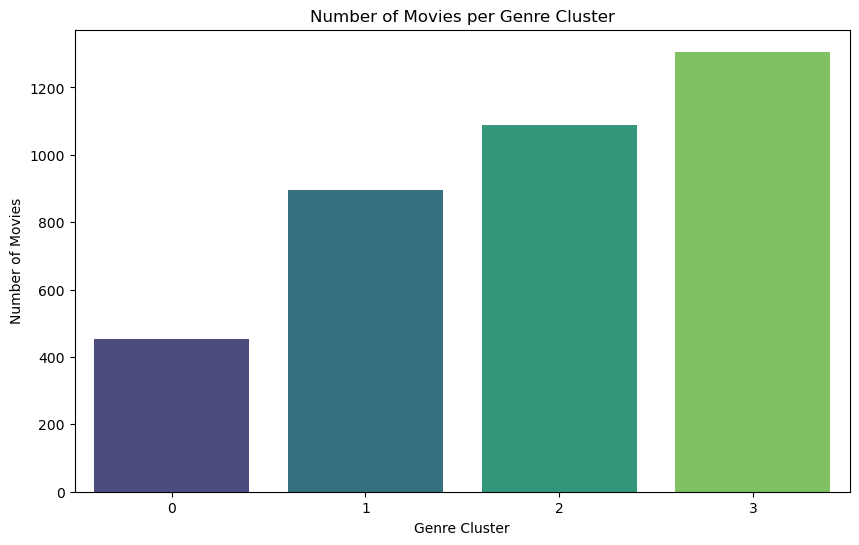

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 确保 'genres' 列为列表格式并处理缺失值
train_data['genres'] = train_data['genres'].apply(lambda x: x if isinstance(x, list) else [])
test_data['genres'] = test_data['genres'].apply(lambda x: x if isinstance(x, list) else [])

# 对 genres 进行二值化编码
mlb = MultiLabelBinarizer()
genres_encoded_train = mlb.fit_transform(train_data['genres'])  # 只 fit 在 train_data 上
genres_encoded_test = mlb.transform(test_data['genres'])  # 在 test_data 上仅使用 transform

# 使用 KMeans 进行聚类（假设分成 5 个类别，可调整）
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(genres_encoded_train)

# 将聚类结果添加到原始数据中
train_data['genre_cluster'] = kmeans.labels_
test_data['genre_cluster'] = kmeans.predict(genres_encoded_test)  # 使用 kmeans 预测 test_data 的聚类

# 查看每个聚类的样本数量
print(train_data['genre_cluster'].value_counts())

# 可视化聚类结果
plt.figure(figsize=(10, 6))
sns.countplot(x='genre_cluster', data=train_data, palette='viridis')
plt.title('Number of Movies per Genre Cluster')
plt.xlabel('Genre Cluster')
plt.ylabel('Number of Movies')
plt.show()


In [58]:
# 查看每个聚类中的 genres 分布
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster} genres distribution:")
    cluster_genres = train_data[train_data['genre_cluster'] == cluster]['genres']
    all_genres = [genre for sublist in cluster_genres for genre in sublist]
    genre_counts = Counter(all_genres)
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).sort_values(by='count', ascending=False)
    print(genre_df.head(5))  # 只显示前 10 个常见的 genres
    print("\n")


Cluster 0 genres distribution:
          count
Horror      367
Thriller    289
Mystery     187
Sci-Fi       59
Crime        51


Cluster 1 genres distribution:
           count
Action       871
Crime        316
Adventure    315
Drama        284
Comedy       187


Cluster 2 genres distribution:
           count
Comedy      1086
Drama        562
Romance      340
Crime        151
Adventure    124


Cluster 3 genres distribution:
           count
Drama       1300
Romance      326
Crime        297
Thriller     235
Biography    198




/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


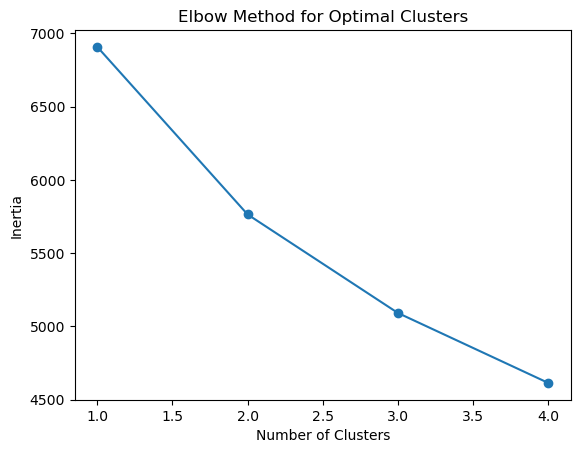

In [59]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 确保 'genres' 列为列表格式并处理缺失值
train_data['genres'] = train_data['genres'].apply(lambda x: x if isinstance(x, list) else [])
test_data['genres'] = test_data['genres'].apply(lambda x: x if isinstance(x, list) else [])

# 对 genres 进行二值化编码
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(train_data['genres'])

# 检查 genres_encoded 是否有内容
if genres_encoded.shape[1] == 0:
    print("Error: genres_encoded is empty.")
else:
    # 测试不同聚类数量
    inertia = []
    for n_clusters in range(1, 5):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans.fit(genres_encoded)
        inertia.append(kmeans.inertia_)

    # 绘制肘部法则图
    plt.plot(range(1, 5), inertia, marker='o')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()


genre_cluster
0    6.190487
1    6.658863
2    7.065257
3    7.254441
Name: DOUBAN_SCORE, dtype: float64


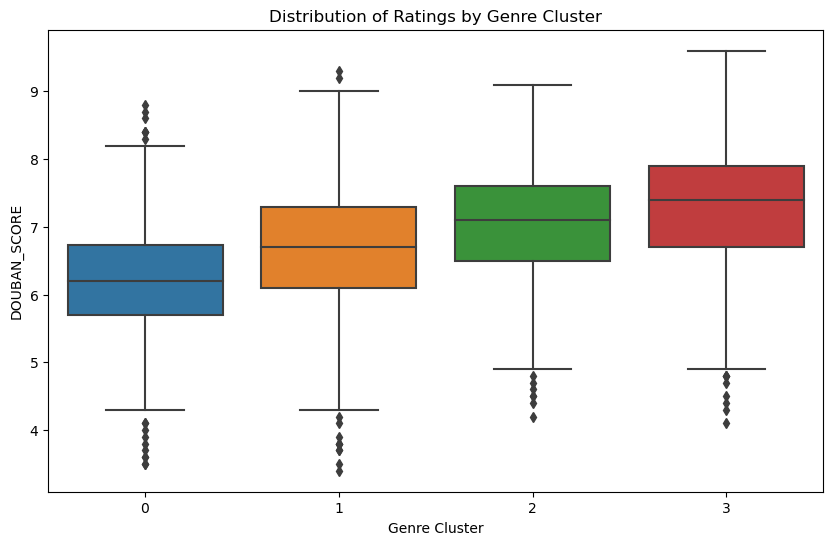

In [60]:
# 将聚类标签与评分合并
train_data['genre_cluster'] = kmeans.labels_
cluster_scores = train_data.groupby('genre_cluster')['DOUBAN_SCORE'].mean()

# 查看每个聚类的平均评分
print(cluster_scores)

# 可视化聚类评分分布
plt.figure(figsize=(10, 6))
sns.boxplot(x='genre_cluster', y='DOUBAN_SCORE', data=train_data)
plt.title('Distribution of Ratings by Genre Cluster')
plt.xlabel('Genre Cluster')
plt.ylabel('DOUBAN_SCORE')
plt.show()


In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3743 entries, 2086 to 860
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         3743 non-null   int64  
 1   rating                       3743 non-null   float64
 2   votes_number                 3743 non-null   float64
 3   runtime                      3743 non-null   float64
 4   certificate                  3743 non-null   object 
 5   countries                    3743 non-null   object 
 6   genres                       3743 non-null   object 
 7   director                     3743 non-null   object 
 8   cast                         3743 non-null   object 
 9   NAME                         3743 non-null   object 
 10  DOUBAN_SCORE                 3743 non-null   float64
 11  GENRES                       3743 non-null   object 
 12  IMDB_ID                      3743 non-null   object 
 13  LANGUAGES            

In [62]:
# One-hot encode the 'genre_cluster' column and add it to the data
from sklearn.preprocessing import OneHotEncoder

# 对 'genre_cluster' 列进行 one-hot 编码
encoder = OneHotEncoder(sparse=False)
genre_cluster_encoded = encoder.fit_transform(train_data[['genre_cluster']])

# 将编码后的 'genre_cluster' 特征转为 DataFrame 并添加到原始数据中
genre_cluster_df = pd.DataFrame(genre_cluster_encoded, columns=[f'cluster_{int(i)}' for i in range(genre_cluster_encoded.shape[1])])
train_data = pd.concat([train_data.reset_index(drop=True), genre_cluster_df], axis=1)


# 对测试集进行 one-hot 编码，使用之前在训练集上 fit 的 encoder
genre_cluster_encoded_test = encoder.transform(test_data[['genre_cluster']])

# 将编码后的 'genre_cluster' 特征转为 DataFrame 并添加到测试数据中
genre_cluster_df_test = pd.DataFrame(genre_cluster_encoded_test, columns=[f'cluster_{int(i)}' for i in range(genre_cluster_encoded_test.shape[1])])
test_data = pd.concat([test_data.reset_index(drop=True), genre_cluster_df_test], axis=1)


/Users/stefanieq/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [63]:
# 改进后的清理函数，不需要再分割字符串
def clean_genres(genres):
    if isinstance(genres, list):
        # 去掉括号和多余符号，标准化为一致的格式
        cleaned_list = [g.strip().replace("'", "").replace('"', "").replace("[", "").replace("]", "") for g in genres]
        return cleaned_list
    else:
        return []

# 应用函数到数据
train_data['genres'] = train_data['genres'].apply(clean_genres)
test_data['genres'] = test_data['genres'].apply(clean_genres)

# 检查和打印唯一类别
all_kind = [genre for genres_list in train_data['genres'] for genre in genres_list]
set_kind = list(set(all_kind))
print(f'genres 特征里面有 {len(set_kind)} 个类别，生成 {len(set_kind)} 个多热变量')

# 多热编码函数
def generate_genre_multihot(genres, set_kind):
    return [1 if genre in genres else 0 for genre in set_kind]

# 使用多热编码函数进行编码
dummys_train = np.array([generate_genre_multihot(genres, set_kind) for genres in train_data['genres']])
for i, kind in enumerate(set_kind):
    train_data[f'genre_{kind}'] = dummys_train[:, i]

dummys_test = np.array([generate_genre_multihot(genres, set_kind) for genres in test_data['genres']])
for i, kind in enumerate(set_kind):
    test_data[f'genre_{kind}'] = dummys_test[:, i]

# 检查结果
print("Train data columns after cleanup:")
print(train_data.columns)


genres 特征里面有 21 个类别，生成 21 个多热变量
Train data columns after cleanup:
Index(['year', 'rating', 'votes_number', 'runtime', 'certificate', 'countries',
       'genres', 'director', 'cast', 'NAME', 'DOUBAN_SCORE', 'GENRES',
       'IMDB_ID', 'LANGUAGES', 'MINS', 'YEAR', 'IMDB_genres_set',
       'Douban_genres_set', 'genres_jaccard', 'genres_difference_count',
       'certificate_freq_encoded', 'countries_frequency',
       'countries_frequency_encoded', 'is_english', 'certificate_encoded',
       'genres_combination', 'genre_cluster', 'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'genre_Mystery', 'genre_History',
       'genre_Comedy', 'genre_Music', 'genre_Western', 'genre_Sci-Fi',
       'genre_Musical', 'genre_Adventure', 'genre_War', 'genre_Action',
       'genre_Animation', 'genre_Sport', 'genre_Fantasy', 'genre_Crime',
       'genre_Family', 'genre_Documentary', 'genre_Drama', 'genre_Horror',
       'genre_Biography', 'genre_Thriller', 'genre_Romance'],
      dtype='object

In [64]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# 初始化新特征列
train_data['IMDB_Genre_Avg_Score'] = 0
train_data['Douban_Genre_Avg_Score'] = 0

# 设置 K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(train_data):
    # 划分训练折叠和验证折叠
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]
    
    # 基于训练折叠计算 IMDb 和豆瓣的类型评分均值
    imdb_genre_avg_score = train_fold.explode('genres').groupby('genres')['DOUBAN_SCORE'].mean().to_dict()
    douban_genre_avg_score = train_fold.explode('GENRES').groupby('GENRES')['DOUBAN_SCORE'].mean().to_dict()
    
    # 将评分均值分配到验证折叠
    train_data.loc[val_idx, 'IMDB_Genre_Avg_Score'] = val_fold['genres'].apply(
        lambda x: np.mean([imdb_genre_avg_score.get(genre, 0) for genre in x])
    )
    train_data.loc[val_idx, 'Douban_Genre_Avg_Score'] = val_fold['GENRES'].apply(
        lambda x: np.mean([douban_genre_avg_score.get(genre, 0) for genre in x])
    )

# 同样的方法应用于测试集，注意这里必须基于整个训练集重新计算均值
imdb_genre_avg_score_final = train_data.explode('genres').groupby('genres')['DOUBAN_SCORE'].mean().to_dict()
douban_genre_avg_score_final = train_data.explode('GENRES').groupby('GENRES')['DOUBAN_SCORE'].mean().to_dict()

test_data['IMDB_Genre_Avg_Score'] = test_data['genres'].apply(
    lambda x: np.mean([imdb_genre_avg_score_final.get(genre, 0) for genre in x])
)
test_data['Douban_Genre_Avg_Score'] = test_data['GENRES'].apply(
    lambda x: np.mean([douban_genre_avg_score_final.get(genre, 0) for genre in x])
)



# 计算高频类型（基于训练集）
top_imdb_genres = train_data.explode('genres')['genres'].value_counts().head(5).index.tolist()
top_douban_genres = train_data.explode('GENRES')['GENRES'].value_counts().head(5).index.tolist()

# 添加二值化特征到训练集和测试集
for genre in top_imdb_genres:
    train_data[f'IMDB_Genre_{genre}'] = train_data['genres'].apply(lambda x: 1 if genre in x else 0)
    test_data[f'IMDB_Genre_{genre}'] = test_data['genres'].apply(lambda x: 1 if genre in x else 0)

for genre in top_douban_genres:
    train_data[f'Douban_Genre_{genre}'] = train_data['GENRES'].apply(lambda x: 1 if genre in x else 0)
    test_data[f'Douban_Genre_{genre}'] = test_data['GENRES'].apply(lambda x: 1 if genre in x else 0)


In [65]:
# 初始化新列
train_data['director_avg_score'] = 0

# 定义 K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Processing fold {fold + 1}...")
    
    # 获取训练折和验证折
    train_fold = train_data.iloc[train_idx]
    val_fold = train_data.iloc[val_idx]
    
    # 计算训练折中的导演评分均值
    director_avg_score = train_fold.groupby('director')['DOUBAN_SCORE'].mean().to_dict()
    
    # 映射验证折的导演评分均值
    val_fold['director_avg_score'] = val_fold['director'].map(director_avg_score)
    
    # 对验证折中未匹配到均值的导演，填充训练折的全局均值
    global_avg = train_fold['DOUBAN_SCORE'].mean()
    val_fold['director_avg_score'].fillna(global_avg, inplace=True)
    
    # 更新到主训练集
    train_data.loc[val_idx, 'director_avg_score'] = val_fold['director_avg_score']

# 确认训练集中是否仍有全 0 的情况
print("Unique values in train_data['director_avg_score']:", train_data['director_avg_score'].unique())

# 对测试集的导演评分均值（基于整个训练集）
director_avg_score = train_data.groupby('director')['DOUBAN_SCORE'].mean().to_dict()
test_data['director_avg_score'] = test_data['director'].map(director_avg_score)

# 对测试集的缺失值填充全局均值
global_avg_test = train_data['DOUBAN_SCORE'].mean()
test_data['director_avg_score'].fillna(global_avg_test, inplace=True)

# 确认测试集中的情况
print("Unique values in test_data['director_avg_score']:", test_data['director_avg_score'].unique())


Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Unique values in train_data['director_avg_score']: [6.1        6.525      6.91903808 6.93956594 6.92674457 6.93333333
 7.46666667 8.7        6.93102872 6.3        8.9        6.46
 7.43333333 5.7        7.6        6.75       7.1        7.9
 6.9248163  7.35       6.25       6.55       8.1        6.92
 7.2        7.775      7.075      6.775      7.7        7.45
 5.35       6.         6.4        9.         6.8        7.8
 8.56666667 6.9        7.         8.3        5.1        6.5
 7.15       7.3        7.475      5.8        6.86666667 7.66666667
 6.65       6.6        7.85       7.83333333 6.96666667 8.2
 7.55       6.23333333 6.43333333 8.1        8.6        7.45
 7.76666667 7.25       7.55       7.43333333 7.21666667 8.45
 6.85       6.2        7.58571429 6.35       5.4        6.88
 6.7        6.95       7.86       6.73333333 7.325      7.05
 7.4        7.18333333 6.625      6.86     

/var/folders/ft/z0nlgwjd10s7scl_pt9wqw500000gn/T/ipykernel_24979/1845257686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold['director_avg_score'] = val_fold['director'].map(director_avg_score)
/var/folders/ft/z0nlgwjd10s7scl_pt9wqw500000gn/T/ipykernel_24979/1845257686.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_fold['director_avg_score'].fillna(global_avg, inplace=True)
/var/folders/ft/z0nlgwjd10s7scl_pt9wqw500000gn/T/ipykernel_24979/1845257686.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [66]:
# 确保 cast 列是列表格式
import ast
train_data['cast'] = train_data['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
test_data['cast'] = test_data['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 初始化新列
train_data['actor_avg_score'] = 0

# 定义 K 折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f"Processing fold {fold + 1}...")
    
    # 获取当前折的训练和验证集
    train_fold = train_data.iloc[train_idx].copy()
    val_fold = train_data.iloc[val_idx].copy()
    
    # 展开演员列
    actors_exploded = train_fold.explode('cast')
    print("Exploded actors data sample:")
    print(actors_exploded.head())
    
    # 计算当前折中每位演员的评分均值
    actor_avg_score = actors_exploded.groupby('cast')['DOUBAN_SCORE'].mean().to_dict()
    print("Actor average score dictionary (sample):")
    print(dict(list(actor_avg_score.items())[:10]))  # 打印部分结果
    
    # 对验证折的演员均值评分
    val_fold['actor_avg_score'] = val_fold['cast'].apply(
        lambda actor_list: np.mean([actor_avg_score.get(actor, 0) for actor in actor_list])
    )
    print("Validation fold actor_avg_score (sample):")
    print(val_fold[['cast', 'actor_avg_score']].head())
    
    # 填回 train_data
    train_data.loc[val_idx, 'actor_avg_score'] = val_fold['actor_avg_score']

# 对测试集计算演员评分均值（基于整个训练集）
actors_exploded = train_data.explode('cast')
actor_avg_score = actors_exploded.groupby('cast')['DOUBAN_SCORE'].mean().to_dict()

test_data['actor_avg_score'] = test_data['cast'].apply(
    lambda actor_list: np.mean([actor_avg_score.get(actor, 0) for actor in actor_list])
)

# 检查结果
print("Training data actor_avg_score description:")
print(train_data['actor_avg_score'].describe())
print("Testing data actor_avg_score description:")
print(test_data['actor_avg_score'].describe())


Processing fold 1...
Exploded actors data sample:
   year  rating  votes_number   runtime certificate countries  \
1  2003     6.3      8.706821  0.165432       PG-13   Germany   
1  2003     6.3      8.706821  0.165432       PG-13   Germany   
1  2003     6.3      8.706821  0.165432       PG-13   Germany   
1  2003     6.3      8.706821  0.165432       PG-13   Germany   
1  2003     6.3      8.706821  0.165432       PG-13   Germany   

                    genres       director                  cast  NAME  ...  \
1  [Drama, Music, Romance]  Robert Altman         Neve Campbell  浮生若舞  ...   
1  [Drama, Music, Romance]  Robert Altman      Malcolm McDowell  浮生若舞  ...   
1  [Drama, Music, Romance]  Robert Altman          James Franco  浮生若舞  ...   
1  [Drama, Music, Romance]  Robert Altman  Barbara E. Robertson  浮生若舞  ...   
1  [Drama, Music, Romance]  Robert Altman          William Dick  浮生若舞  ...   

   IMDB_Genre_Action IMDB_Genre_Crime IMDB_Genre_Thriller Douban_Genre_Drama  \
1         

In [67]:
train_data['actor_avg_score'].describe()

count    3743.000000
mean        3.352616
std         1.293917
min         0.000000
25%         2.488812
50%         3.479467
75%         4.227918
max         7.875758
Name: actor_avg_score, dtype: float64

In [68]:
import ast

# 定义函数，将字符串解析为列表并计算长度
def count_members(member_list):
    try:
        # 将字符串转换为列表
        member_list = ast.literal_eval(member_list) if isinstance(member_list, str) else member_list
        return len(member_list) if isinstance(member_list, list) else 0
    except (ValueError, SyntaxError):
        return 0

# 计算演员人数并添加为新特征
train_data['cast_num'] = train_data['cast'].apply(count_members)
test_data['cast_num'] = test_data['cast'].apply(count_members)  # 对测试集进行同样的处理

# 查看结果
print("Training Data:")
print(train_data[['cast', 'cast_num']].head())

print("\nTest Data:")
print(test_data[['cast', 'cast_num']].head())


Training Data:
                                                cast  cast_num
0  [Teri Andrez, Adam Barrie, Megan Wolfley, Robe...        67
1  [Neve Campbell, Malcolm McDowell, James Franco...        81
2  [Ajay Devgn, Ranbir Kapoor, Nana Patekar, Arju...        23
3  [Stephen Dorff, Brad Renfro, Fairuza Balk, Nor...        61
4  [Mario Casas, Ana Wagener, Jose Coronado, Bárb...        26

Test Data:
                                                cast  cast_num
0  [Macaulay Culkin, Kanin Howell, Alexis Kirschn...        23
1  [Adrien Brody, Emilia Fox, Michal Zebrowski, E...        94
2  [Amitabh Bachchan, Akshay Kumar, Priyanka Chop...        12
3  [Blythe Danner, June Squibb, Rhea Perlman, Mar...        51
4  [Charlie Rowe, Karl Urban, Angourie Rice, John...        13


In [69]:
import pandas as pd

# 设置基准年份为2019年
base_year = 2019

# 计算电影年龄并填充缺失值 - 训练集
train_data['movie_age'] = (base_year - train_data['year']).fillna((base_year - train_data['year'].mean())).astype(int)

# 计算电影年龄并填充缺失值 - 测试集
test_data['movie_age'] = (base_year - test_data['year']).fillna((base_year - test_data['year'].mean())).astype(int)

# 查看结果
print("Train data:")
print(train_data[['year', 'movie_age']].head())

print("\nTest data:")
print(test_data[['year', 'movie_age']].head())


Train data:
   year  movie_age
0  2009         10
1  2003         16
2  2010          9
3  2002         17
4  2016          3

Test data:
   year  movie_age
0  1994         25
1  2002         17
2  2005         14
3  2015          4
4  2013          6


In [70]:
# 确保 train_data 已加载

# 计算 runtime 和 MINS 列中相等的比例
equal_count = train_data[train_data['runtime'] == train_data['MINS']].shape[0]
total_count = train_data.shape[0]
equal_ratio = equal_count / total_count

print(f"runtime 和 MINS 相等的比例: {equal_ratio:.2%}")


runtime 和 MINS 相等的比例: 86.40%


In [71]:
# 创建新特征，表示 runtime 和 MINS 是否相等 - 训练集
train_data['runtime_MINS_match'] = (train_data['runtime'] == train_data['MINS']).astype(int)

# 创建新特征，表示 runtime 和 MINS 是否相等 - 测试集
test_data['runtime_MINS_match'] = (test_data['runtime'] == test_data['MINS']).astype(int)

# 查看训练集中的前几行
print("Train data:")
print(train_data[['runtime', 'MINS', 'runtime_MINS_match']].head())

# 查看测试集中的前几行
print("\nTest data:")
print(test_data[['runtime', 'MINS', 'runtime_MINS_match']].head())

# 检查 runtime_MINS_match 特征与 douban_score 的关系
correlation = train_data[['runtime_MINS_match', 'DOUBAN_SCORE']].corr().iloc[0, 1]
print(f"\nruntime_MINS_match 与 douban_score 的相关性: {correlation:.2f}")


Train data:
    runtime      MINS  runtime_MINS_match
0  0.138272  0.138272                   1
1  0.165432  0.165432                   1
2  0.291358  0.291358                   1
3  0.125926  0.125926                   1
4  0.150617  0.150617                   1

Test data:
    runtime      MINS  runtime_MINS_match
0  0.086420  0.086420                   1
1  0.259259  0.259259                   1
2  0.266667  0.266667                   1
3  0.116049  0.116049                   1
4  0.103704  0.103704                   1

runtime_MINS_match 与 douban_score 的相关性: 0.01


In [72]:
## MODELfit

In [73]:
# 删除多列
train_data.drop(columns=['LANGUAGES','IMDB_ID', 'certificate','countries','genres','cast','director','NAME','GENRES','LANGUAGES','YEAR'], inplace=True)
test_data.drop(columns=['LANGUAGES','IMDB_ID', 'certificate','countries','genres','cast','director','NAME','GENRES','LANGUAGES','YEAR'], inplace=True)


In [74]:
train_data.drop(columns=['genres_combination'], inplace=True)

In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3743 entries, 0 to 3742
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         3743 non-null   int64  
 1   rating                       3743 non-null   float64
 2   votes_number                 3743 non-null   float64
 3   runtime                      3743 non-null   float64
 4   DOUBAN_SCORE                 3743 non-null   float64
 5   MINS                         3743 non-null   float64
 6   IMDB_genres_set              3743 non-null   object 
 7   Douban_genres_set            3743 non-null   object 
 8   genres_jaccard               3743 non-null   float64
 9   genres_difference_count      3743 non-null   int64  
 10  certificate_freq_encoded     3743 non-null   int64  
 11  countries_frequency          3743 non-null   object 
 12  countries_frequency_encoded  3047 non-null   float64
 13  is_english        

In [76]:
# 删除多列
train_data.drop(columns=['IMDB_genres_set','Douban_genres_set','genres_jaccard'], inplace=True)
test_data.drop(columns=['IMDB_genres_set','Douban_genres_set','genres_jaccard'], inplace=True)


In [77]:
train_data.drop(columns=['year','MINS'], inplace=True)
test_data.drop(columns=['year','MINS'], inplace=True)


In [78]:
train_data.drop(columns=['countries_frequency'], inplace=True)
test_data.drop(columns=['countries_frequency'], inplace=True)


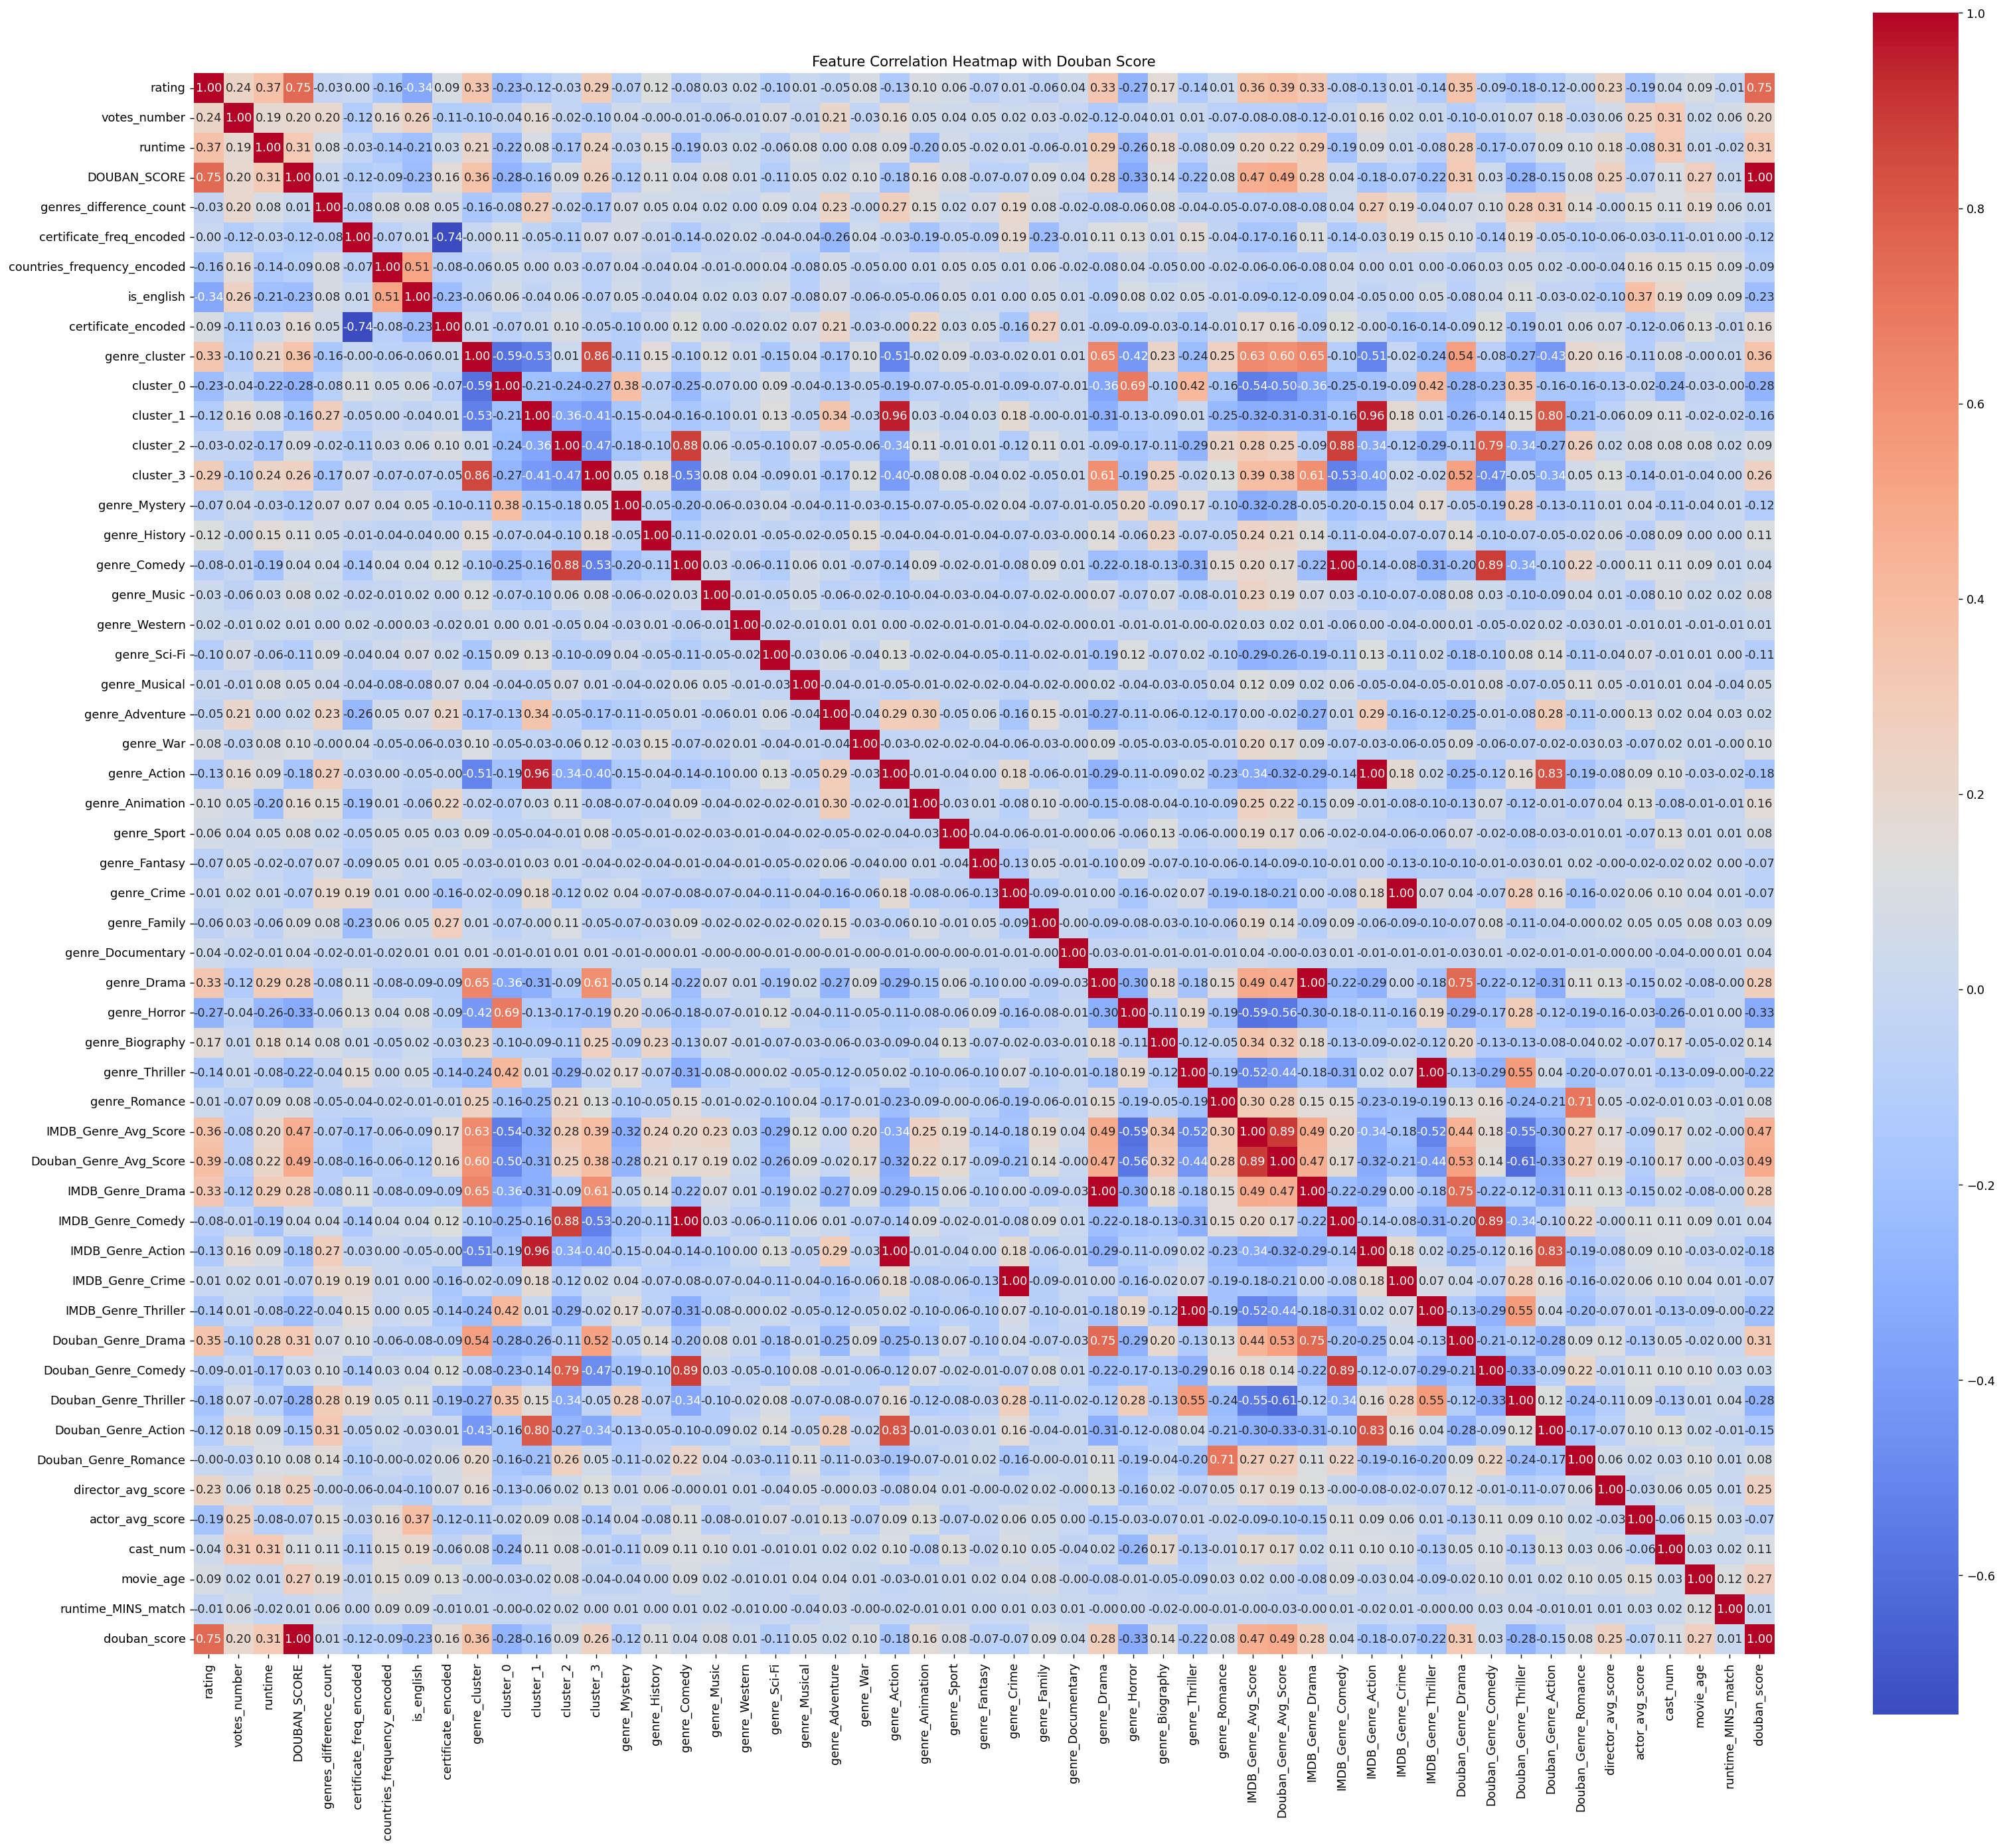

In [79]:

# 创建一个包含目标变量的 DataFrame 用于相关性分析
data_with_target = train_data.assign(douban_score=train_data['DOUBAN_SCORE'])

# 计算 Spearman 相关性矩阵
corr_matrix = data_with_target.corr(method='spearman')

# 绘制相关性热力图
plt.figure(figsize=(30, 26), dpi=128)
sns.heatmap(corr_matrix, annot=True, square=True, cmap='coolwarm', fmt=".2f")

# 显示图表
plt.title('Feature Correlation Heatmap with Douban Score')
plt.show()


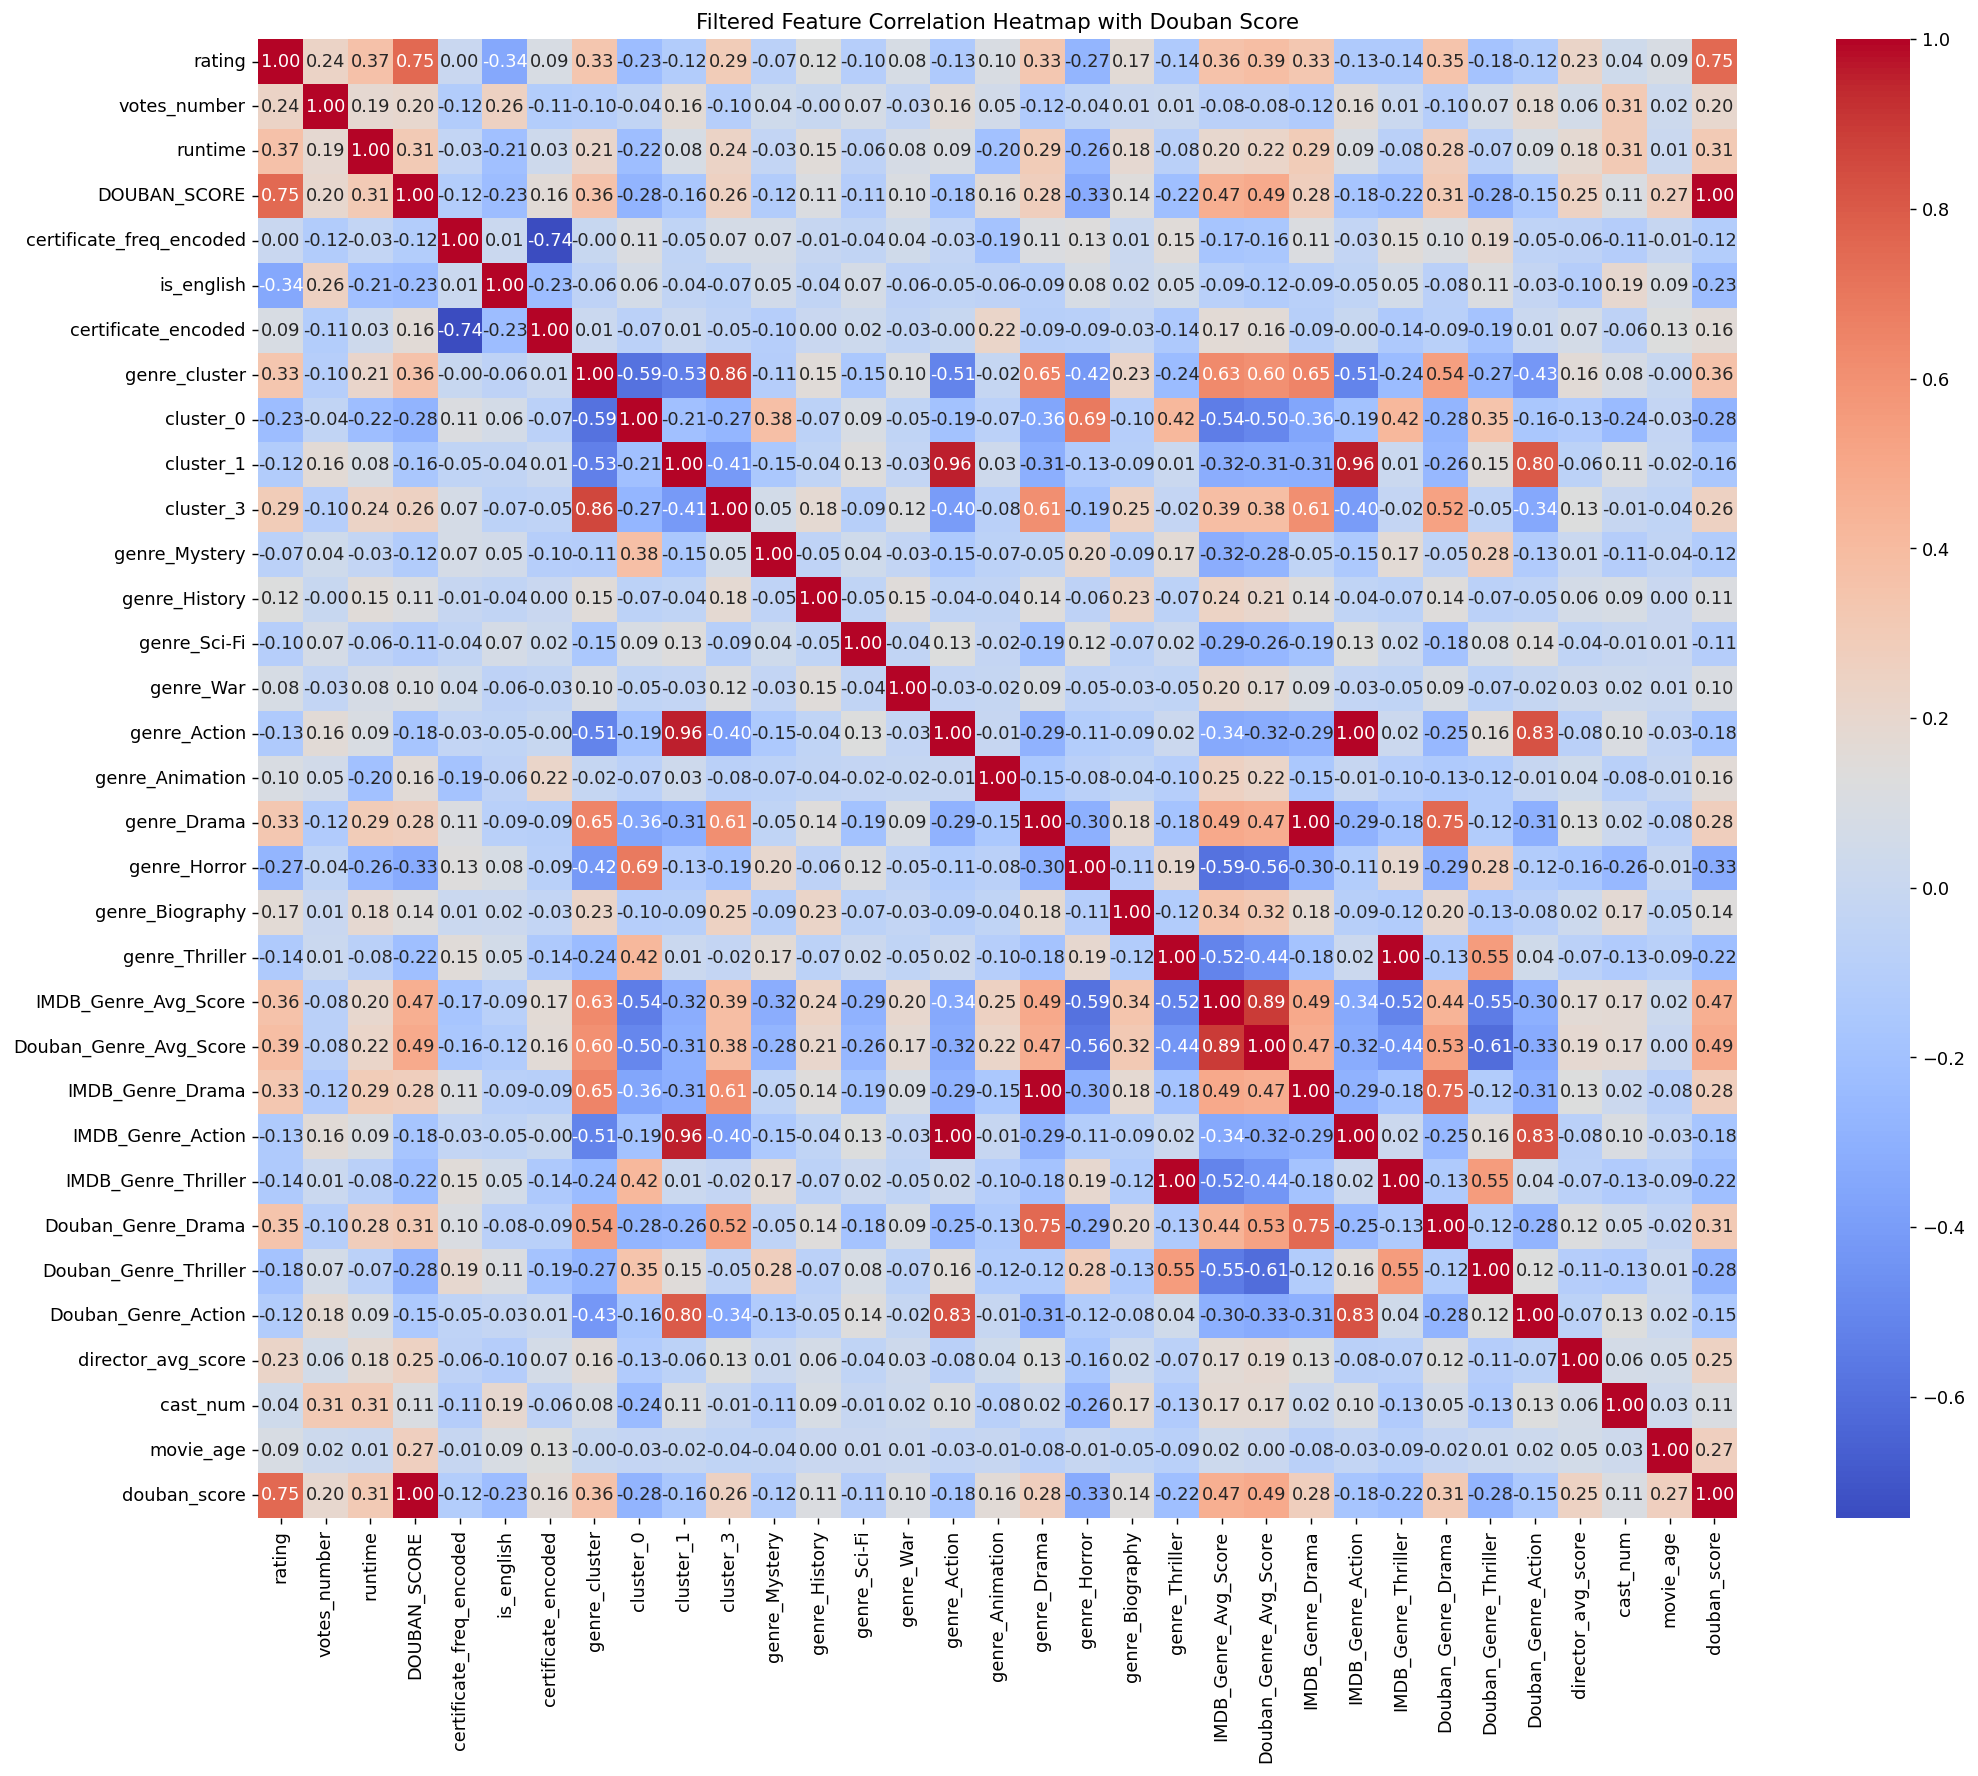

In [80]:

# 创建一个包含目标变量的 DataFrame 用于相关性分析
data_with_target = train_data.assign(douban_score=train_data['DOUBAN_SCORE'])

# 计算 Spearman 相关性矩阵
corr_matrix = data_with_target.corr(method='spearman')

# 筛选与目标变量相关性绝对值大于 0.10 的特征
target_corr = corr_matrix['douban_score']  # 目标变量的相关性
filtered_corr = target_corr[abs(target_corr) > 0.1]  # 筛选阈值
filtered_features = filtered_corr.index  # 获取筛选后的特征名称

# 生成筛选后的相关性矩阵
filtered_corr_matrix = corr_matrix.loc[filtered_features, filtered_features]

# 绘制相关性热力图
plt.figure(figsize=(20, 15), dpi=128)
sns.heatmap(filtered_corr_matrix, annot=True, square=True, cmap='coolwarm', fmt=".2f", cbar=True)

# 显示图表
plt.title('Filtered Feature Correlation Heatmap with Douban Score')
plt.savefig('Filtered Feature Correlation Heatmap with Douban Score.png', dpi=300, bbox_inches='tight')

plt.show()




# 基线模型

In [81]:
from sklearn.svm import SVR

# 1. 准备数据
X_baseline = train_data[['rating']].values  # 使用 IMDb 评分作为基准特征
y = train_data['DOUBAN_SCORE'].values  # 目标变量为豆瓣评分

# 2. 标准化特征（适用于线性回归，树模型无需标准化）
scaler = StandardScaler()
X_baseline_s = scaler.fit_transform(X_baseline)  # 标准化整个数据集（线性模型需要）

# 3. 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100,verbose=-1),
    'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 4. 定义交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=0)  # 10折交叉验证

# 5. 交叉验证和评估
results = []

for name, model in models.items():
    print(f"Cross-validating {name}...")
    
    # 线性回归用标准化数据，其他模型用原始数据
    if name == 'Linear Regression':
        X_data = X_baseline_s
    else:
        X_data = X_baseline
    
    # 计算交叉验证的 R² 和负 MSE
    r2_scores = cross_val_score(model, X_data, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X_data, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均指标
    mean_r2 = np.mean(r2_scores)
    mean_mse = -np.mean(mse_scores)  # 还原为正的 MSE
    mean_rmse = np.sqrt(mean_mse)   # 计算 RMSE
    
    results.append({
        'Model': name,
        'Mean R2': mean_r2,
        'Mean RMSE': mean_rmse,
        'Mean MSE': mean_mse
    })

# 6. 输出结果
results_df = pd.DataFrame(results)
print(results_df)


Cross-validating Linear Regression...
Cross-validating Random Forest...
Cross-validating Gradient Boosting...
Cross-validating XGBoost...
Cross-validating LightGBM...
Cross-validating SVR...
               Model   Mean R2  Mean RMSE  Mean MSE
0  Linear Regression  0.543567   0.636339  0.404927
1      Random Forest  0.550001   0.631732  0.399085
2  Gradient Boosting  0.551533   0.630617  0.397678
3            XGBoost  0.548172   0.632894  0.400555
4           LightGBM  0.555097   0.628190  0.394623
5                SVR  0.555611   0.627870  0.394221


## a. Does the inclusion of cultural or regional features significantly enhance the prediction model accuracy?
### (aover and above that from using the IMDb rating alone?)

                 Model        Feature Added   Mean R²  Mean RMSE
0    Linear Regression  certificate_encoded  0.557377   0.626424
1        Random Forest  certificate_encoded  0.560460   0.625165
2    Gradient Boosting  certificate_encoded  0.587476   0.605303
3              XGBoost  certificate_encoded  0.552078   0.631199
4             LightGBM  certificate_encoded  0.583947   0.607656
..                 ...                  ...       ...        ...
97       Random Forest  Douban_Genre_Action  0.533683   0.643573
98   Gradient Boosting  Douban_Genre_Action  0.547624   0.633678
99             XGBoost  Douban_Genre_Action  0.523815   0.650234
100           LightGBM  Douban_Genre_Action  0.552122   0.630665
101                SVR  Douban_Genre_Action  0.561511   0.623877

[102 rows x 4 columns]


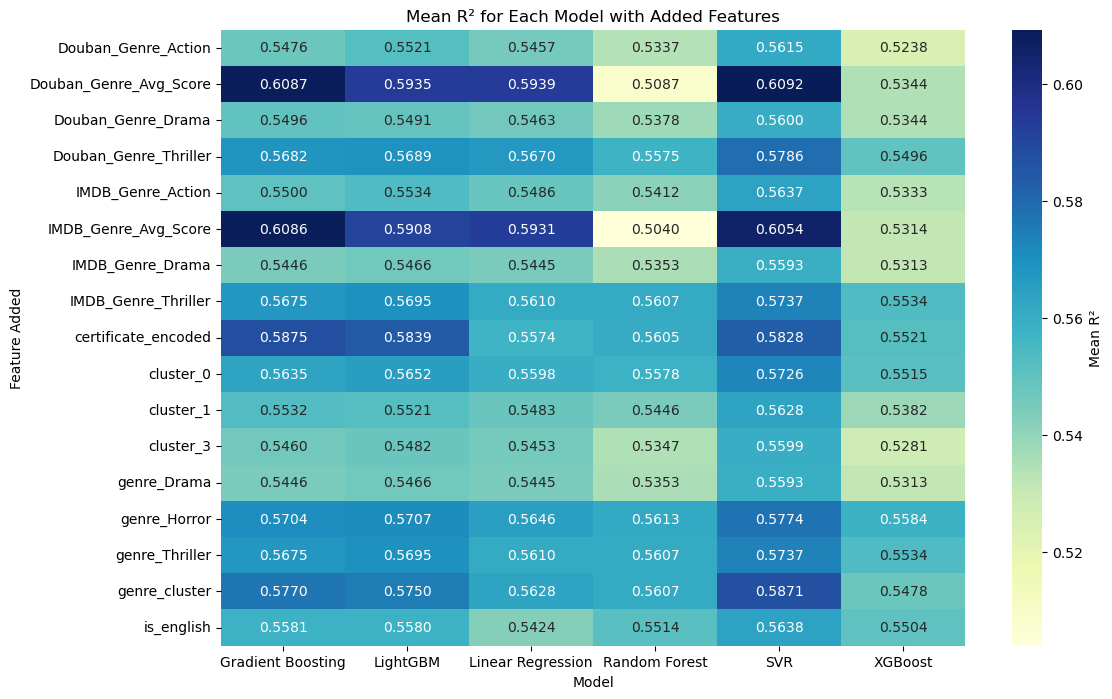

In [83]:
# 定义统一的评估函数
def evaluate_cultural_features(models, X_baseline, y, cultural_features, standardize=False, n_splits=10):
    from sklearn.model_selection import KFold, cross_val_score
    results = []
    
    # 定义 K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for feature in cultural_features:
        # 动态扩展特征集
        X = train_data[['rating', feature]].values
        
        if standardize:  # 如果需要标准化（如线性回归）
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        
        for name, model in models.items():
            # 计算交叉验证 R² 和负 MSE
            r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
            mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
            
            # 平均指标
            mean_r2 = np.mean(r2_scores)
            mean_rmse = np.sqrt(-np.mean(mse_scores))
            
            # 记录结果
            results.append({
                'Model': name,
                'Feature Added': feature,
                'Mean R²': mean_r2,
                'Mean RMSE': mean_rmse
            })
    
    return pd.DataFrame(results)

# 定义模型字典
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1),
    'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')

}

# 文化特征列表
cultural_features = [
    'certificate_encoded', 'is_english','genre_cluster','cluster_0','cluster_1','cluster_3',
    'genre_Thriller', 'genre_Drama', 'genre_Horror', 'IMDB_Genre_Drama', 'Douban_Genre_Drama',
    'IMDB_Genre_Thriller', 'Douban_Genre_Thriller', 'IMDB_Genre_Avg_Score', 'Douban_Genre_Avg_Score',
    'IMDB_Genre_Action', 'Douban_Genre_Action'
]

# 加载和准备数据
X_baseline = train_data[['rating']].values
y = train_data['DOUBAN_SCORE'].values

# 评估所有模型
all_results = evaluate_cultural_features(models, X_baseline, y, cultural_features, standardize=False)

# 打印结果
print(all_results)

# 创建透视表，以 "Feature Added" 为行，"Model" 为列，值为 Mean R²
pivot_table = all_results.pivot(index='Feature Added', columns='Model', values='Mean R²')

# 可视化为热力图
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean R²'})
plt.title("Mean R² for Each Model with Added Features")
plt.ylabel("Feature Added")
plt.xlabel("Model")
plt.show()


Multi-Cultural Feature Model Performance with Cross-Validation:
               Model   Mean R²  Mean RMSE
0  Linear Regression  0.605020   0.591241
1      Random Forest  0.604712   0.592207
2  Gradient Boosting  0.632065   0.571257
3            XGBoost  0.582063   0.609187
4           LightGBM  0.627575   0.574788
5                SVR  0.615713   0.583576


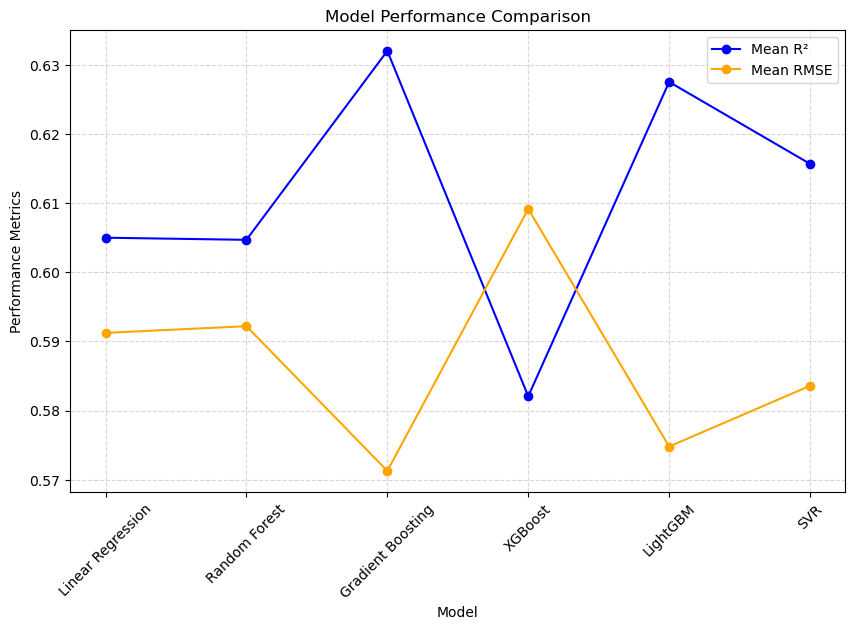

In [85]:
# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1),
    'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 定义高贡献特征
selected_features = [
    'rating',  # 基线特征
    'certificate_encoded',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'is_english',
    'Douban_Genre_Thriller',
    'IMDB_Genre_Thriller',
    'genre_Thriller',
    'genre_cluster'
]

# 加载数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义交叉验证
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果
results = []

# 遍历模型并进行交叉验证
for name, model in models.items():
    # 计算交叉验证 R² 和负 MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均性能指标
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 记录结果
    results.append({
        'Model': name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print("Multi-Cultural Feature Model Performance with Cross-Validation:")
print(results_df)

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(results_df['Model'], results_df['Mean R²'], marker='o', label='Mean R²', color='blue')
plt.plot(results_df['Model'], results_df['Mean RMSE'], marker='o', label='Mean RMSE', color='orange')
plt.title('Model Performance Comparison')
plt.ylabel('Performance Metrics')
plt.xlabel('Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()



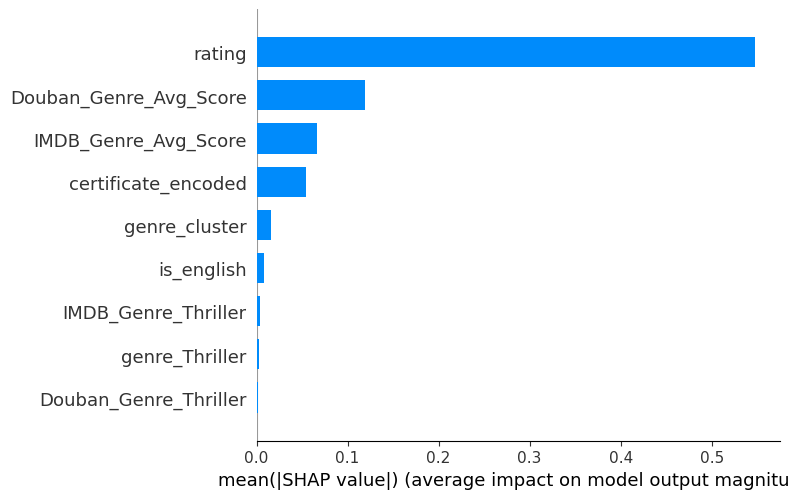

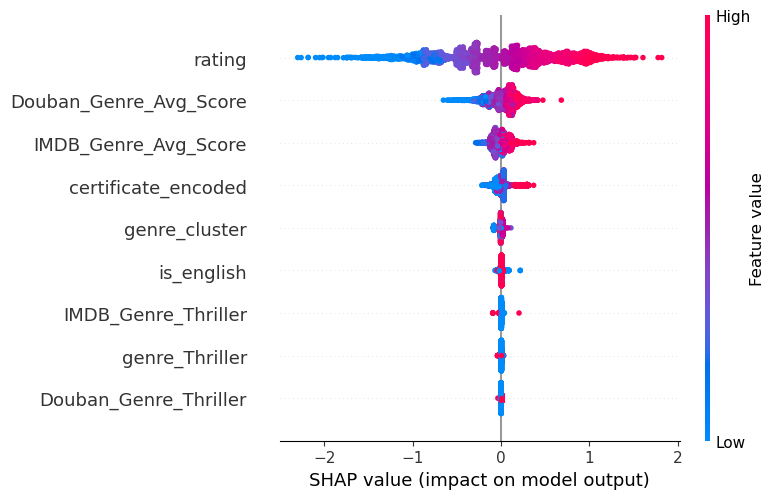

SHAP Feature Importance:
                  Feature  Mean SHAP Value
0                  rating         0.547626
2  Douban_Genre_Avg_Score         0.118852
3    IMDB_Genre_Avg_Score         0.065887
1     certificate_encoded         0.054347
8           genre_cluster         0.015967
4              is_english         0.008564
6     IMDB_Genre_Thriller         0.003256
7          genre_Thriller         0.003078
5   Douban_Genre_Thriller         0.001802


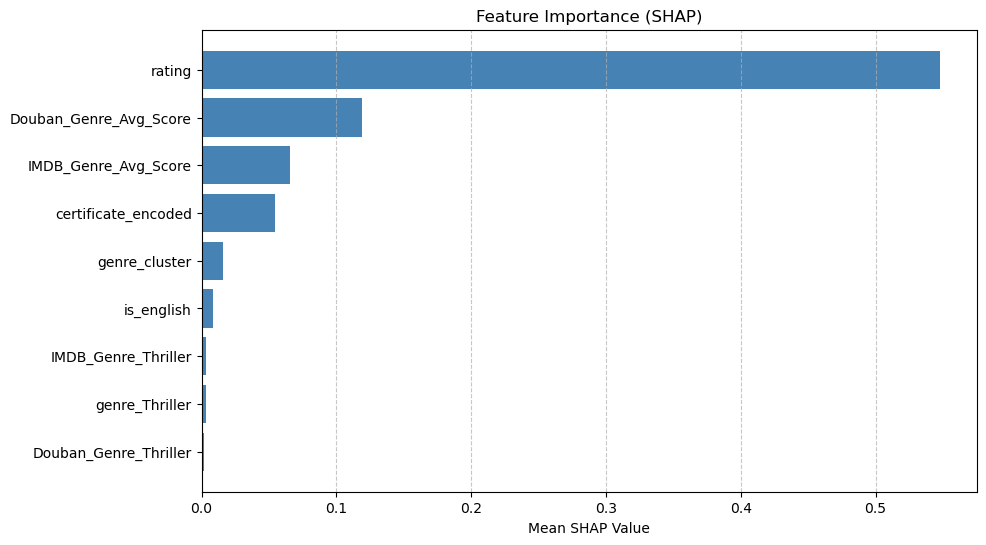

In [87]:
# 1. 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 2. 定义初始特征
selected_features = [
    'rating',  # 基线特征
    'certificate_encoded',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'is_english',
    'Douban_Genre_Thriller',
    'IMDB_Genre_Thriller',
    'genre_Thriller',
    'genre_cluster'
]

# 加载数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 3. 选择最佳模型进行特征重要性分析
best_model_name = 'Gradient Boosting'  # 假设 Gradient Boosting 是最佳模型
best_model = models[best_model_name]

# 模型训练（在整个数据集上训练）
best_model.fit(X, y)

# 4. 使用 SHAP 分析特征重要性
import shap

if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    # 树模型使用 TreeExplainer
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X)
elif best_model_name == 'Linear Regression':
    # 线性模型使用 LinearExplainer
    explainer = shap.LinearExplainer(best_model, X)
    shap_values = explainer(X)
else:
    # 其他模型使用 KernelExplainer
    explainer = shap.KernelExplainer(best_model.predict, X)
    shap_values = explainer(X)

# 5. 绘制 SHAP 特征重要性图
# (a) 柱状图
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=selected_features)

# (b) 散点图
shap.summary_plot(shap_values, X, feature_names=selected_features)

# 6. 打印特征重要性
shap_importance = pd.DataFrame({
    'Feature': selected_features,
    'Mean SHAP Value': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='Mean SHAP Value', ascending=False)

print("SHAP Feature Importance:")
print(shap_importance)

# 可视化特征重要性排名
plt.figure(figsize=(10, 6))
plt.barh(shap_importance['Feature'], shap_importance['Mean SHAP Value'], color='steelblue')
plt.title('Feature Importance (SHAP)')
plt.xlabel('Mean SHAP Value')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


## 最终文化特征模型

Model Performance with Cross-Validation:
               Model   Mean R²  Mean RMSE
0  Linear Regression  0.604587   0.591556
1      Random Forest  0.605092   0.591937
2  Gradient Boosting  0.632015   0.571314
3            XGBoost  0.581312   0.609645
4           LightGBM  0.626220   0.575749
5                SVR  0.619562   0.580690


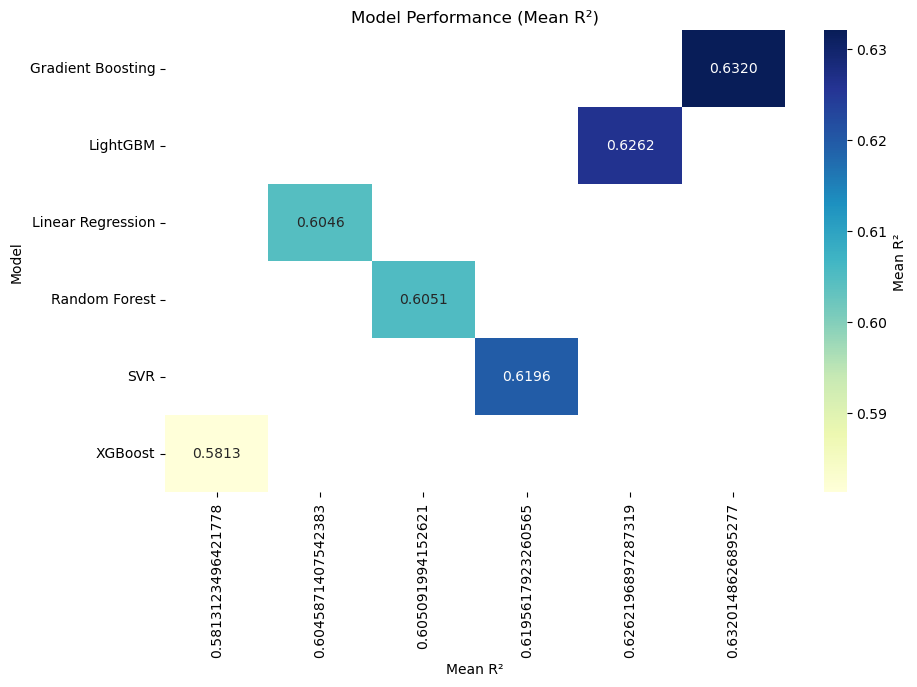

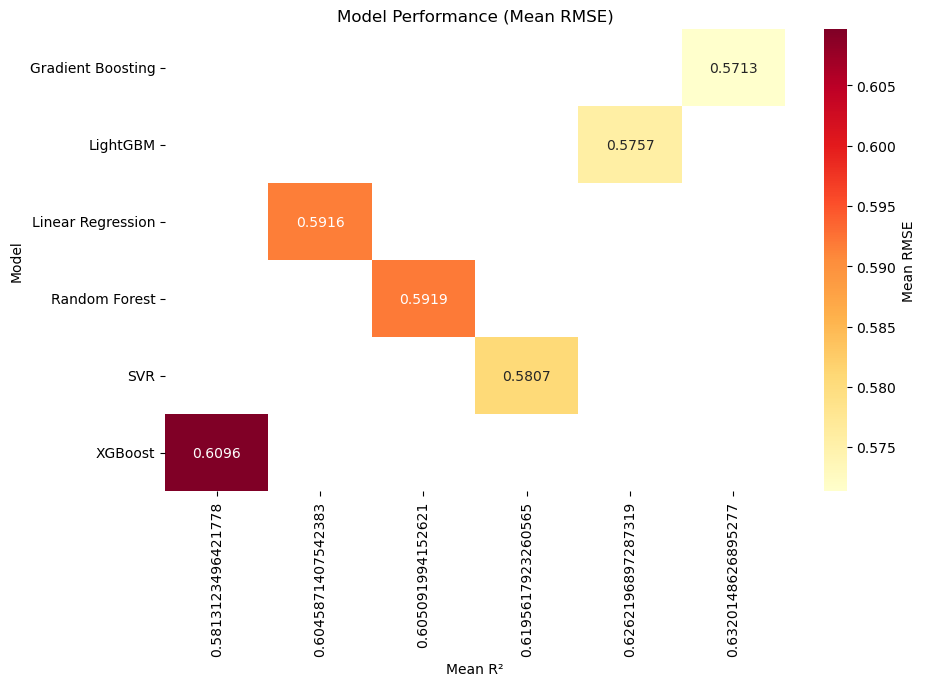

In [89]:
# 只留下5个文化特征

# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1),
    'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 定义高贡献特征
selected_features = [
    'rating',  # 基线特征
    'certificate_encoded',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'genre_cluster',
    'is_english'
]

# 准备数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义交叉验证
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果
results = []

# 遍历模型并进行交叉验证
for name, model in models.items():
    # 计算交叉验证 R² 和负 MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均性能指标
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 记录结果
    results.append({
        'Model': name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print("Model Performance with Cross-Validation:")
print(results_df)

# 绘制热力图（R²）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    results_df.pivot(index='Model',columns='Mean R²', values='Mean R²'),
    annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean R²'}
)
plt.title("Model Performance (Mean R²)")
plt.ylabel("Model")
plt.show()

# 绘制热力图（RMSE）
plt.figure(figsize=(10, 6))
sns.heatmap(
    results_df.pivot(index='Model',columns='Mean R²', values='Mean RMSE'),
    annot=True, fmt=".4f", cmap="YlOrRd", cbar_kws={'label': 'Mean RMSE'}
)
plt.title("Model Performance (Mean RMSE)")
plt.ylabel("Model")
plt.show()


Model Performance with Cross-Validation:
               Model   Mean R²  Mean RMSE
0  Linear Regression  0.604676   0.591518
1      Random Forest  0.600134   0.595663
2  Gradient Boosting  0.631502   0.571717
3            XGBoost  0.578361   0.612004
4           LightGBM  0.625975   0.576104
5                SVR  0.619763   0.580544


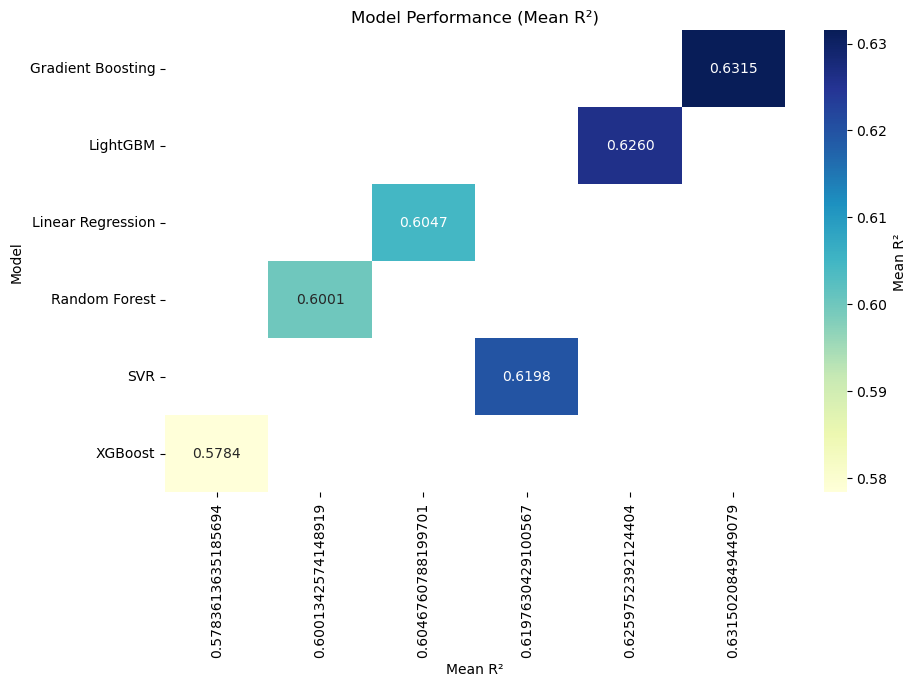

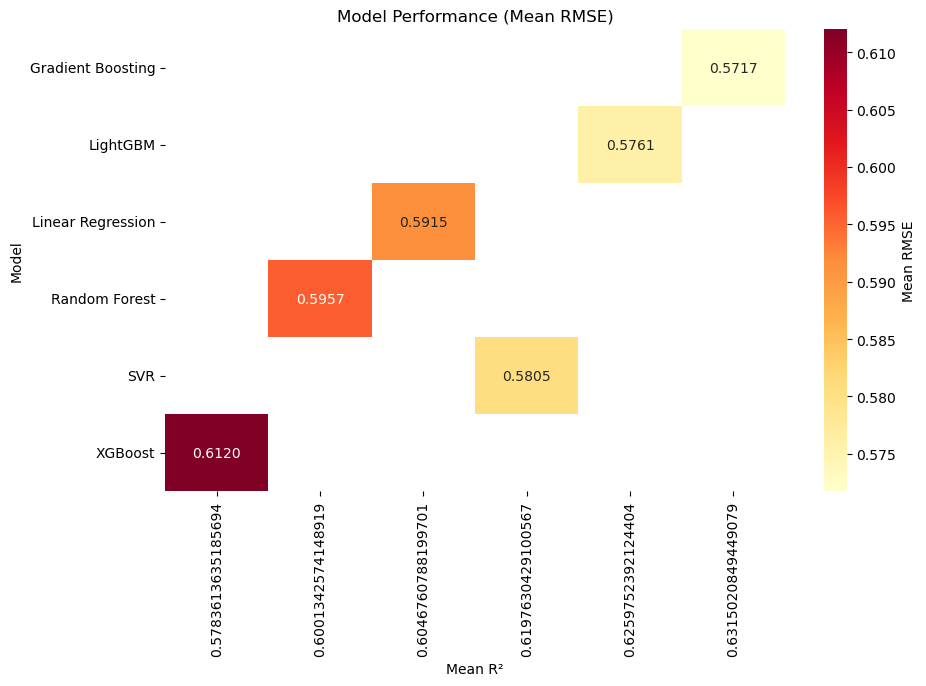

In [91]:
# 只留下4个文化特征

# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1),
    'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 定义高贡献特征
selected_features = [
    'rating',  # 基线特征
    'certificate_encoded',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'genre_cluster'
]

# 准备数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义交叉验证
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果
results = []

# 遍历模型并进行交叉验证
for name, model in models.items():
    # 计算交叉验证 R² 和负 MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均性能指标
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 记录结果
    results.append({
        'Model': name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print("Model Performance with Cross-Validation:")
print(results_df)

# 绘制热力图（R²）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    results_df.pivot(index='Model',columns='Mean R²', values='Mean R²'),
    annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean R²'}
)
plt.title("Model Performance (Mean R²)")
plt.ylabel("Model")
plt.show()

# 绘制热力图（RMSE）
plt.figure(figsize=(10, 6))
sns.heatmap(
    results_df.pivot(index='Model',columns='Mean R²', values='Mean RMSE'),
    annot=True, fmt=".4f", cmap="YlOrRd", cbar_kws={'label': 'Mean RMSE'}
)
plt.title("Model Performance (Mean RMSE)")
plt.ylabel("Model")
plt.show()


In [ ]:
# 创建交互特征
train_data['Genre_Score_Diff'] = train_data['Douban_Genre_Avg_Score'] - train_data['IMDB_Genre_Avg_Score']
train_data['Genre_Score_Ratio'] = train_data['Douban_Genre_Avg_Score'] / (train_data['IMDB_Genre_Avg_Score'] + 1e-5)  # 防止除零

# 如果有测试集，也要添加同样的特征
test_data['Genre_Score_Diff'] = test_data['Douban_Genre_Avg_Score'] - test_data['IMDB_Genre_Avg_Score']
test_data['Genre_Score_Ratio'] = test_data['Douban_Genre_Avg_Score'] / (test_data['IMDB_Genre_Avg_Score'] + 1e-5)

# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1)
}

# 定义高贡献特征
selected_features = [
    'rating',  # 基线特征
    'certificate_label_encoded',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'country_freq_encoded',
    'Genre_Score_Diff',
    'Genre_Score_Ratio'
]

# 准备数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义交叉验证
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果
results = []

# 遍历模型并进行交叉验证
for name, model in models.items():
    # 计算交叉验证 R² 和负 MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均性能指标
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 记录结果
    results.append({
        'Model': name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print("Model Performance with Cross-Validation:")
print(results_df)

# 绘制 R² 和 RMSE 的条形图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.plot(results_df['Model'], results_df['Mean R²'], marker='o', label='Mean R²', color='blue')
plt.plot(results_df['Model'], results_df['Mean RMSE'], marker='o', label='Mean RMSE', color='orange')
plt.title('Model Performance Comparison')
plt.ylabel('Performance Metrics')
plt.xlabel('Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()


In [ ]:
import shap

# 假设你选择了一个模型，例如 Gradient Boosting
best_model = GradientBoostingRegressor(random_state=0, n_estimators=100)

# 确保模型已经训练好
best_model.fit(X, y)

# 使用 SHAP 进行特征重要性分析
explainer = shap.TreeExplainer(best_model)  # 针对树模型使用 TreeExplainer
shap_values = explainer(X)

# 绘制特征重要性（柱状图）
shap.summary_plot(shap_values, X, plot_type="bar", feature_names=selected_features)

# 绘制特征重要性（散点图）
shap.summary_plot(shap_values, X, feature_names=selected_features)


In [ ]:
features_to_check = ['Douban_Genre_Avg_Score', 'IMDB_Genre_Avg_Score', 'Genre_Score_Diff', 'Genre_Score_Ratio']
correlation_matrix = train_data[features_to_check].corr()
print(correlation_matrix)

##Genre_Score_Diff 和 Genre_Score_Ratio 的关系：
##两者的相关系数高达 0.993，说明它们之间几乎完全线性相关。这意味着在模型中保留这两个特征同时存在可能是冗余的，只需要选择一个。



In [ ]:
# 创建交互特征
train_data['Genre_Score_Diff'] = train_data['Douban_Genre_Avg_Score'] - train_data['IMDB_Genre_Avg_Score']
train_data['Genre_Score_Ratio'] = train_data['Douban_Genre_Avg_Score'] / (train_data['IMDB_Genre_Avg_Score'] + 1e-5)  # 防止除零

# 如果有测试集，也要添加同样的特征
test_data['Genre_Score_Diff'] = test_data['Douban_Genre_Avg_Score'] - test_data['IMDB_Genre_Avg_Score']
test_data['Genre_Score_Ratio'] = test_data['Douban_Genre_Avg_Score'] / (test_data['IMDB_Genre_Avg_Score'] + 1e-5)

# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, n_estimators=100),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1)
}

# 定义高贡献特征
selected_features = [
    'rating',  # 基线特征
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'country_freq_encoded',
    'certificate_label_encoded',
    'is_english',
    'Genre_Score_Diff',
    'Genre_Score_Ratio'
]

# 准备数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义交叉验证
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 存储结果
results = []

# 遍历模型并进行交叉验证
for name, model in models.items():
    # 计算交叉验证 R² 和负 MSE
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # 计算平均性能指标
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 记录结果
    results.append({
        'Model': name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print("Model Performance with Cross-Validation:")
print(results_df)

# 绘制 R² 和 RMSE 的折线图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Model'], results_df['Mean R²'], marker='o', label='Mean R²', color='blue')
plt.plot(results_df['Model'], results_df['Mean RMSE'], marker='o', label='Mean RMSE', color='orange')
plt.title('Model Performance Comparison')
plt.ylabel('Performance Metrics')
plt.xlabel('Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor


# 定义模型
models = {
    'HistGrandientBoosting Regressor':HistGradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=0, n_estimators=100),
    'LightGBM': LGBMRegressor(random_state=0, n_estimators=100, verbosity=-1)
}

# 定义高贡献特征（需根据你的图表具体调整）
selected_features = [
    'rating',  # 基线特征
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'country_freq_encoded',
    'certificate_label_encoded',
    'director_avg_score',
    'actor_avg_score'

]

# 分割数据集
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 存储结果
results = []

# 遍历模型并训练
for name, model in models.items():
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # 计算评估指标
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    # 记录结果
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Validation R²': val_r2,
        'Validation RMSE': val_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印透视表
print("Multi-culfeature Model Performance:")
print(results_df)



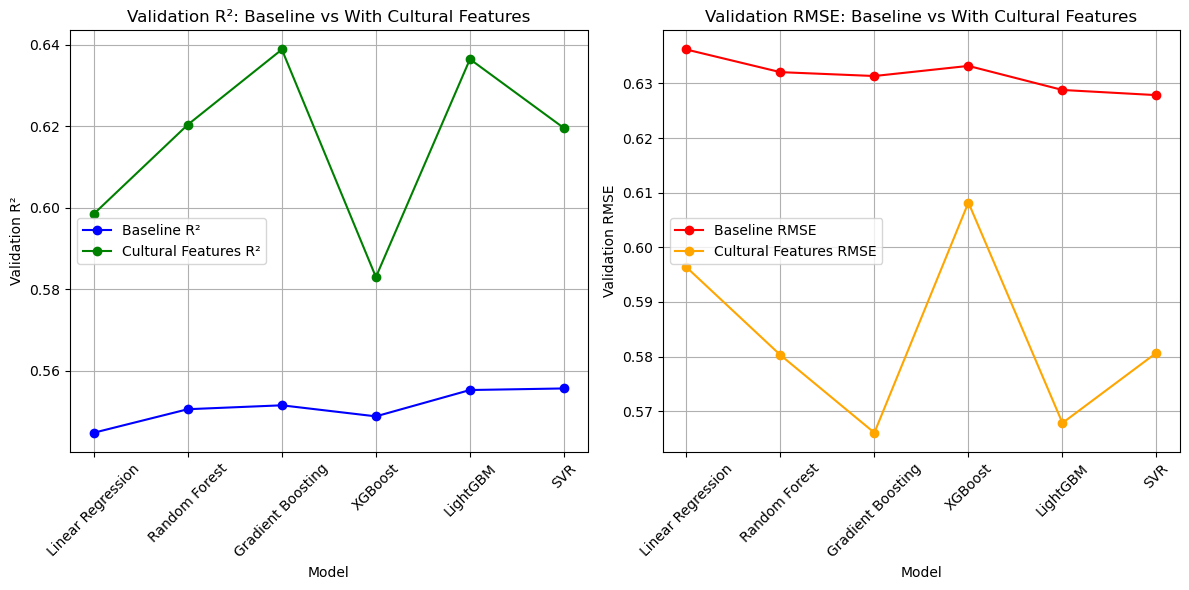

In [93]:
import matplotlib.pyplot as plt

# 模型名称
models = ["Linear Regression", "Random Forest", "Gradient Boosting", "XGBoost", "LightGBM","SVR"]

# 基线模型结果
baseline_r2 = [0.544730, 0.550511, 0.551469, 0.548755, 0.555223, 0.555611]
baseline_rmse = [0.636227, 0.632079, 0.631370, 0.633222, 0.628814, 0.627870]

# 加入文化特征后的结果
culture_r2 = [0.598479, 0.620411, 0.638874, 0.582969, 0.636497, 0.619562]
culture_rmse = [0.596378, 0.580283, 0.566044, 0.608198, 0.567833, 0.580690]


# 绘制折线图
plt.figure(figsize=(12, 6))

# R² 曲线
plt.subplot(1, 2, 1)
plt.plot(models, baseline_r2, marker='o', label='Baseline R²', color='blue')
plt.plot(models, culture_r2, marker='o', label='Cultural Features R²', color='green')
plt.title("Validation R²: Baseline vs With Cultural Features")
plt.ylabel("Validation R²")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# RMSE 曲线
plt.subplot(1, 2, 2)
plt.plot(models, baseline_rmse, marker='o', label='Baseline RMSE', color='red')
plt.plot(models, culture_rmse, marker='o', label='Cultural Features RMSE', color='orange')
plt.title("Validation RMSE: Baseline vs With Cultural Features")
plt.ylabel("Validation RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# 展示图表
plt.tight_layout()
plt.show()


## b. Which specific features about the movies in use, combine more strongly with an IMDb rating to improve the accuracy of the prediction model?

Evaluating feature set: Baseline
Evaluating feature set: Baseline + Genre
Evaluating feature set: Baseline + Genre + Cast
Evaluating feature set: Baseline + Genre + Cast + Director
Evaluating feature set: Baseline + Genre + Cast + Director + Culture
Evaluating feature set: All Features
                                     Feature Set              Model   Mean R²  \
0                                       Baseline  Linear Regression  0.543554   
1                                       Baseline      Random Forest  0.549204   
2                                       Baseline  Gradient Boosting  0.550855   
3                                       Baseline            XGBoost  0.551264   
4                                       Baseline           LightGBM  0.556330   
5                                       Baseline                SVR  0.554981   
6                               Baseline + Genre  Linear Regression  0.607777   
7                               Baseline + Genre      Random Fore

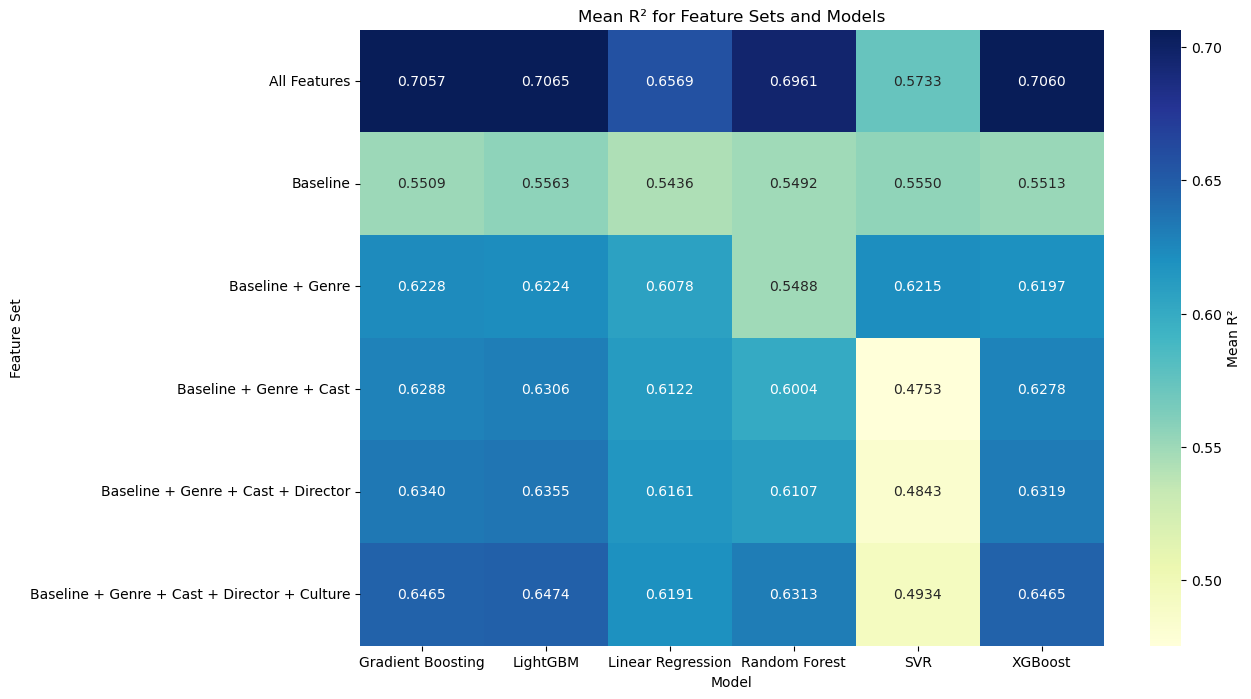

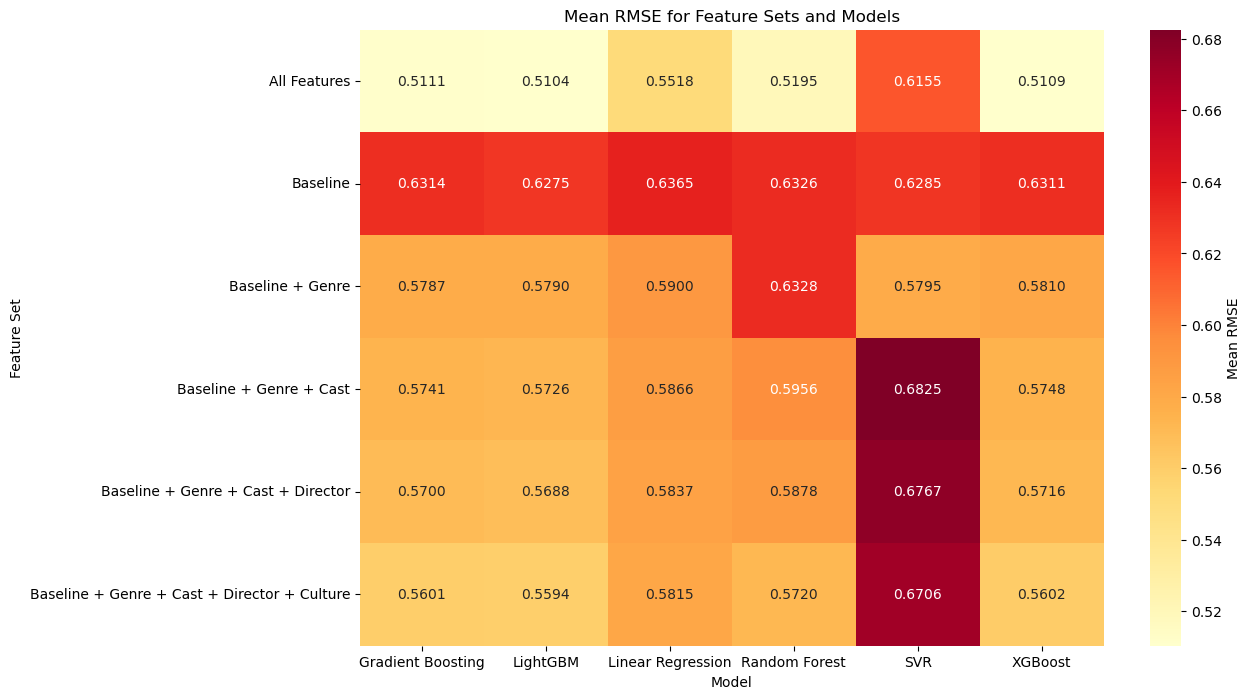

In [109]:


# 定义目标变量
y = train_data['DOUBAN_SCORE']

# 定义特征类别
baseline_features = ['rating']  # 基线特征：IMDb评分
genre_features = [col for col in train_data.columns if col.startswith('genre_')]
cast_features = ['actor_avg_score', 'cast_num']  # 演员特征
director_features = ['director_avg_score']  # 导演特征
culture_features = ['Douban_Genre_Avg_Score', 'IMDB_Genre_Avg_Score', 'genre_cluster','certificate_encoded', 'is_english']
other_features = ['runtime', 'movie_age', 'votes_number']  # 其他特征

# 特征组合
feature_sets = {
    'Baseline': baseline_features,
    'Baseline + Genre': baseline_features + genre_features,
    'Baseline + Genre + Cast': baseline_features + genre_features + cast_features,
    'Baseline + Genre + Cast + Director': baseline_features + genre_features + cast_features + director_features,
    'Baseline + Genre + Cast + Director + Culture': baseline_features + genre_features + cast_features + director_features + culture_features,
    'All Features': baseline_features + genre_features + cast_features + director_features + culture_features + other_features,
}

# 定义模型
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=0, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0),
     'SVR' : SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale')
}

# 定义交叉验证函数
def evaluate_model_with_cv(X, y, model, cv=5):
    """交叉验证评估模型性能"""
    # 定义 R² 和 RMSE 评分
    r2_scorer = make_scorer(r2_score)
    neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # 计算交叉验证 R² 和负均方误差
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)
    neg_mse_scores = cross_val_score(model, X, y, cv=cv, scoring=neg_mse_scorer)
    
    # 平均 R² 和 RMSE
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.sqrt(-np.mean(neg_mse_scores))
    
    return mean_r2, mean_rmse

# 存储结果
results = []

# 遍历特征组合和模型
for feature_set_name, features in feature_sets.items():
    print(f"Evaluating feature set: {feature_set_name}")
    X = train_data[features].values  # 获取当前特征集数据
    
    for model_name, model in models.items():
        mean_r2, mean_rmse = evaluate_model_with_cv(X, y, model, cv=5)  # 5折交叉验证
        results.append({
            'Feature Set': feature_set_name,
            'Model': model_name,
            'Mean R²': mean_r2,
            'Mean RMSE': mean_rmse
        })

# 转换为 DataFrame 并展示结果
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("results_feature_sets_models.csv", index=False)

# 可视化结果
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
pivot_r2 = results_df.pivot(index='Feature Set', columns='Model', values='Mean R²')
pivot_rmse = results_df.pivot(index='Feature Set', columns='Model', values='Mean RMSE')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_r2, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Mean R²'})
plt.title("Mean R² for Feature Sets and Models")
plt.xlabel("Model")
plt.ylabel("Feature Set")
plt.savefig("heatmap_mean_r2.png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图片
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_rmse, annot=True, fmt=".4f", cmap="YlOrRd", cbar_kws={'label': 'Mean RMSE'})
plt.title("Mean RMSE for Feature Sets and Models")
plt.xlabel("Model")
plt.ylabel("Feature Set")
plt.savefig("heatmap_mean_rmse.png", dpi=300, bbox_inches='tight')  # 保存为高分辨率图片
plt.show()


In [116]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# 选择最佳模型和特征集
best_features = feature_sets['All Features']
X = train_data[best_features]
y = train_data['DOUBAN_SCORE']  # 确保目标变量已定义

# 训练模型
model = GradientBoostingRegressor(random_state=0, n_estimators=100)
model.fit(X, y)

# SHAP 分析
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# 可视化特征重要性
plt.figure()  # 创建一个新的图形对象
shap.summary_plot(shap_values, X, show=False)  # show=False 禁止直接显示图像
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')  # 保存为高分辨率 PNG 文件
plt.close()  # 关闭图像，释放内存


Evaluating Random Forest with 10-fold cross-validation...
Evaluating SVR with 10-fold cross-validation...
Evaluating LightGBM with 10-fold cross-validation...
Evaluating XGBoost with 10-fold cross-validation...
Evaluating Gradient Boosting with 10-fold cross-validation...
Model Performance with 10-Fold Cross-Validation:
               Model   Mean R²  Mean RMSE
0      Random Forest  0.696892   0.518125
1                SVR  0.583556   0.607363
2           LightGBM  0.703236   0.512655
3            XGBoost  0.673808   0.537349
4  Gradient Boosting  0.705733   0.510540


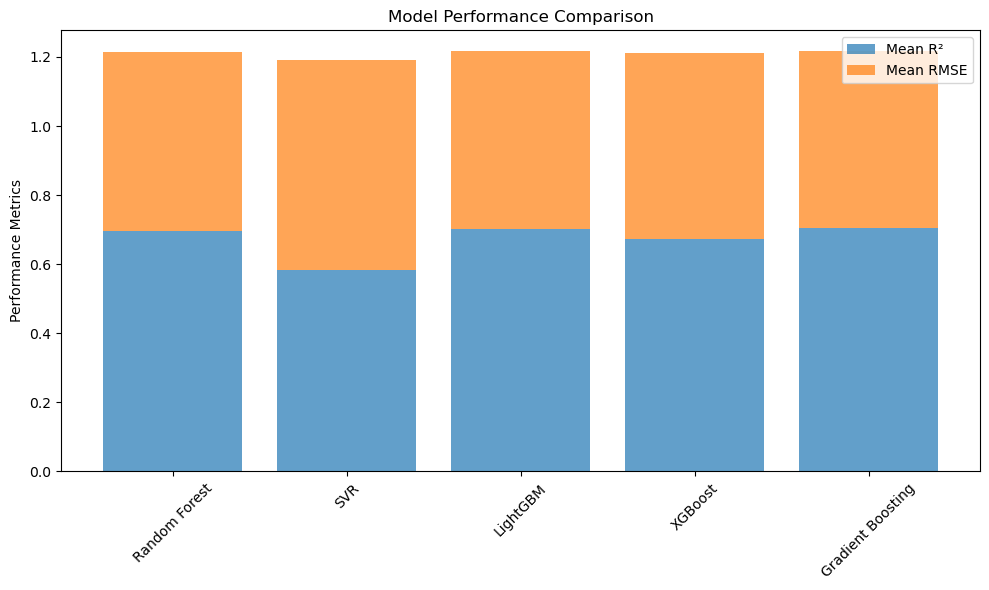

In [101]:

# 更新重要特征列表
selected_features = [
    'rating',
    'movie_age',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'votes_number',
    'director_avg_score',
    'certificate_encoded',
    'runtime',
    'cast_num',
    'genre_Action',
    'actor_avg_score',
    'genre_Family',
    'genre_Biography',
    'genre_cluster',
    'is_english'
]

# 更新数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义模型（使用默认参数）
models = {
    'Random Forest': RandomForestRegressor(random_state=0),
    'SVR': SVR(kernel='rbf'),
    'LightGBM': LGBMRegressor(random_state=0),
    'XGBoost': XGBRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0)
}

# 存储结果
model_performance = []

# 定义自定义评分函数（以 R² 为主要评分指标）
scoring_r2 = make_scorer(r2_score)

# 遍历模型并使用 10 次交叉验证
for model_name, model in models.items():
    print(f"Evaluating {model_name} with 10-fold cross-validation...")
    
    # 交叉验证 R²
    r2_scores = cross_val_score(model, X, y, cv=10, scoring=scoring_r2, n_jobs=-1)
    mean_r2 = np.mean(r2_scores)
    
    # 交叉验证 RMSE（负均方误差转正并开平方）
    mse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 存储结果
    model_performance.append({
        'Model': model_name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame 并打印结果
performance_df = pd.DataFrame(model_performance)
print("Model Performance with 10-Fold Cross-Validation:")
print(performance_df)

# 绘制性能比较图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['Mean R²'], label='Mean R²', alpha=0.7)
plt.bar(performance_df['Model'], performance_df['Mean RMSE'], label='Mean RMSE', alpha=0.7, bottom=performance_df['Mean R²'])
plt.ylabel('Performance Metrics')
plt.title('Model Performance Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Evaluating Random Forest with 10-fold cross-validation...
Evaluating SVR with 10-fold cross-validation...
Evaluating LightGBM with 10-fold cross-validation...
Evaluating XGBoost with 10-fold cross-validation...
Evaluating Gradient Boosting with 10-fold cross-validation...
Model Performance with 10-Fold Cross-Validation:
               Model   Mean R²  Mean RMSE
0      Random Forest  0.694899   0.519799
1                SVR  0.573315   0.614764
2           LightGBM  0.701893   0.513763
3            XGBoost  0.668647   0.541542
4  Gradient Boosting  0.703209   0.512770


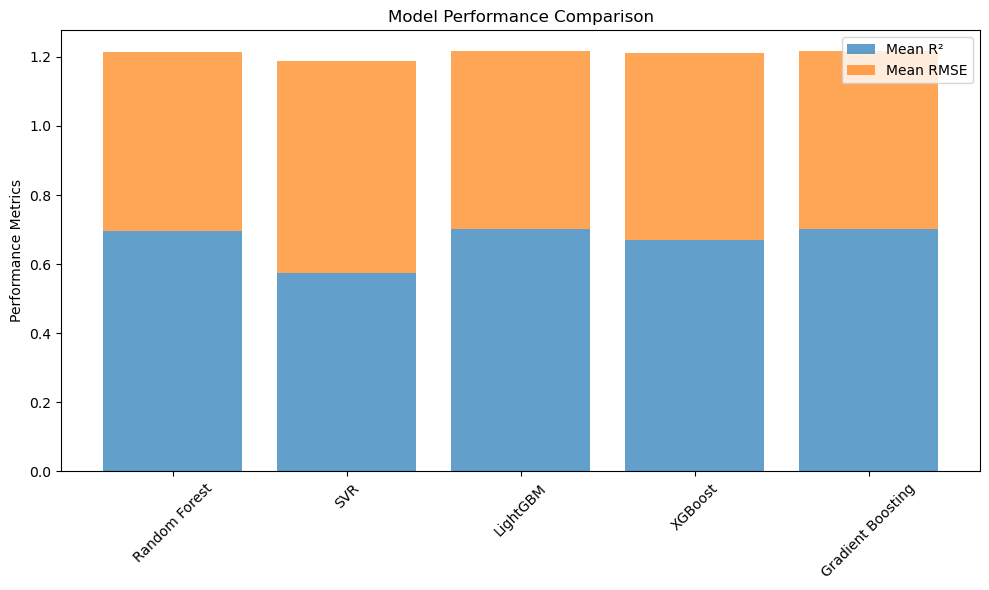

In [102]:
##找最佳feature, 最佳模型, 精简版


# 更新重要特征列表
selected_features = [
    'rating',
    'movie_age',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'votes_number',
    'director_avg_score',
    'certificate_encoded',
    'runtime',
    'cast_num'
]

# 更新数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义模型（使用默认参数）
models = {
    'Random Forest': RandomForestRegressor(random_state=0),
    'SVR': SVR(kernel='rbf'),
    'LightGBM': LGBMRegressor(random_state=0),
    'XGBoost': XGBRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0)
}

# 存储结果
model_performance = []

# 定义自定义评分函数（以 R² 为主要评分指标）
scoring_r2 = make_scorer(r2_score)

# 遍历模型并使用 10 次交叉验证
for model_name, model in models.items():
    print(f"Evaluating {model_name} with 10-fold cross-validation...")
    
    # 交叉验证 R²
    r2_scores = cross_val_score(model, X, y, cv=10, scoring=scoring_r2, n_jobs=-1)
    mean_r2 = np.mean(r2_scores)
    
    # 交叉验证 RMSE（负均方误差转正并开平方）
    mse_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    mean_rmse = np.sqrt(-np.mean(mse_scores))
    
    # 存储结果
    model_performance.append({
        'Model': model_name,
        'Mean R²': mean_r2,
        'Mean RMSE': mean_rmse
    })

# 转换为 DataFrame 并打印结果
performance_df = pd.DataFrame(model_performance)
print("Model Performance with 10-Fold Cross-Validation:")
print(performance_df)

# 绘制性能比较图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(performance_df['Model'], performance_df['Mean R²'], label='Mean R²', alpha=0.7)
plt.bar(performance_df['Model'], performance_df['Mean RMSE'], label='Mean RMSE', alpha=0.7, bottom=performance_df['Mean R²'])
plt.ylabel('Performance Metrics')
plt.title('Model Performance Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [103]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
# 更新重要特征列表
selected_features = [
    'rating',
    'movie_age',
    'Douban_Genre_Avg_Score',
    'IMDB_Genre_Avg_Score',
    'votes_number',
    'director_avg_score',
    'certificate_encoded',
    'runtime',
    'cast_num'
]

# 更新数据
X = train_data[selected_features].values
y = train_data['DOUBAN_SCORE'].values

# 定义自定义评分函数（以 R² 为主要评分指标）
scoring = make_scorer(r2_score)

# 定义模型及参数网格
param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=0),
        'params': {
            'n_estimators': [100, 300, 500],  # 树的数量
            'max_depth': [None, 10, 20],      # 最大深度
            'min_samples_split': [2, 5, 10]   # 最小分裂样本数
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf'),
        'params': {
            'C': [1.0, 10.0, 100.0],          # 惩罚系数
            'epsilon': [0.1, 0.2, 0.5],       # 容忍误差
            'gamma': ['scale', 'auto']        # 核函数系数
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=0, verbose=-1),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],  # 学习率
            'n_estimators': [100, 200, 500],     # 树的数量
            'max_depth': [3, 5, 10]              # 最大深度
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=0, verbosity=0),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],  # 学习率
            'n_estimators': [100, 200, 500],     # 树的数量
            'max_depth': [3, 5, 10]              # 最大深度
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=0),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],  # 学习率
            'n_estimators': [100, 200, 500],     # 树的数量
            'max_depth': [3, 5, 10]              # 最大深度
        }
    }
}

# 存储调参结果
best_models = {}

# 遍历模型和参数网格
for model_name, config in param_grids.items():
    print(f"Starting grid search for {model_name}...")
    model = config['model']
    param_grid = config['params']
    
    # 定义 GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=5,  # 5 折交叉验证
        verbose=1,  # 显示搜索过程
        n_jobs=-1   # 使用所有可用 CPU
    )
    
    # 执行网格搜索
    grid_search.fit(X, y)
    
    # 存储最佳模型和参数
    best_models[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# 输出最终结果（仅显示最优参数和得分）
print("\nSummary of Best Results:")
for model_name, result in best_models.items():
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Best R² Score: {result['best_score']:.4f}")


Starting grid search for Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Starting grid search for SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting grid search for LightGBM...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Starting grid search for XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Starting grid search for Gradient Boosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Summary of Best Results:
Random Forest:
  Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
  Best R² Score: 0.6945
SVR:
  Best Parameters: {'C': 100.0, 'epsilon': 0.2, 'gamma': 'scale'}
  Best R² Score: 0.6800
LightGBM:
  Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Best R² Score: 0.7051
XGBoost:
  Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
  Best R² Score: 0.7035
Gradient Boosting:
  Best Para

Training and evaluating Random Forest...
  Mean CV R²: 0.6985
Training and evaluating SVR...
  Mean CV R²: 0.6789
Training and evaluating LightGBM...
  Mean CV R²: 0.7047
Training and evaluating XGBoost...
  Mean CV R²: 0.7066
Training and evaluating Gradient Boosting...
  Mean CV R²: 0.7040

Final Test Results:
               Model  Mean CV R²   Test R²  Test RMSE
0      Random Forest    0.698470  0.701731   0.513984
1                SVR    0.678915  0.657365   0.550886
2           LightGBM    0.704675  0.693025   0.521431
3            XGBoost    0.706591  0.691823   0.522451
4  Gradient Boosting    0.703958  0.693713   0.520847


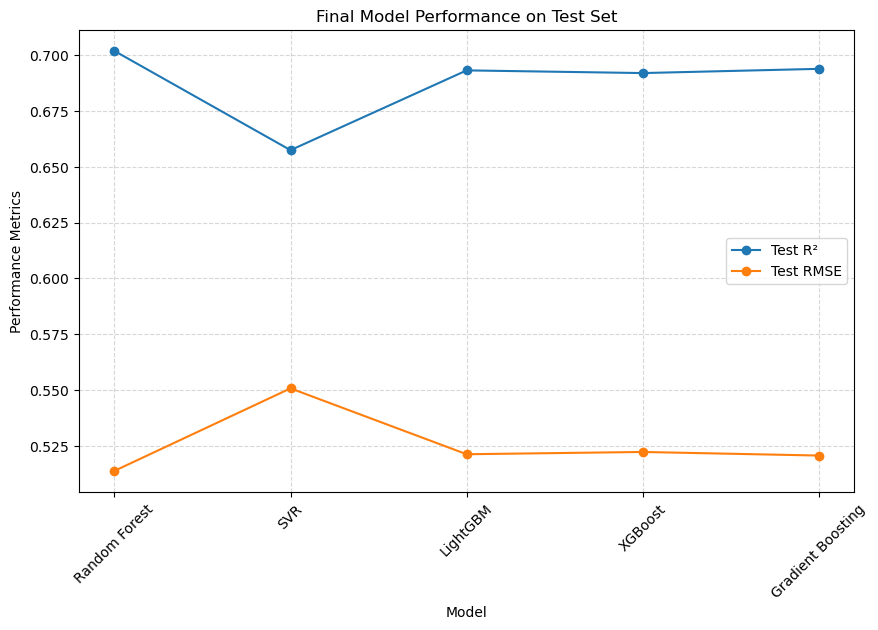

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 更新数据：训练集和测试集
X_train = train_data[selected_features].values
y_train = train_data['DOUBAN_SCORE'].values
X_test = test_data[selected_features].values
y_test = test_data['DOUBAN_SCORE'].values

# 定义模型及最佳参数
final_models = {
    'Random Forest': RandomForestRegressor(
        random_state=0,
        n_estimators=500,
        max_depth=10,
        min_samples_split=2
    ),
    'SVR': SVR(
        kernel='rbf',
        C=100.0,
        epsilon=0.2,
        gamma='scale'
    ),
    'LightGBM': LGBMRegressor(
        random_state=0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=100,
        verbose=-1
    ),
    'XGBoost': XGBRegressor(
        random_state=0,
        verbosity=0,
        learning_rate=0.05,
        max_depth=3,
        n_estimators=500
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        random_state=0,
        learning_rate=0.05,
        max_depth=3,
        n_estimators=200
    )
}

# 存储测试结果
test_results = []

# 遍历最终模型
for model_name, model in final_models.items():
    print(f"Training and evaluating {model_name}...")

    # 10折交叉验证 (训练集)
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    mean_cv_r2 = np.mean(cv_scores)
    print(f"  Mean CV R²: {mean_cv_r2:.4f}")

    # 在训练集上拟合模型
    model.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred = model.predict(X_test)

    # 计算测试集 R² 和 RMSE
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # 保存结果
    test_results.append({
        'Model': model_name,
        'Mean CV R²': mean_cv_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })

# 转换为 DataFrame 展示结果
import pandas as pd
results_df = pd.DataFrame(test_results)

# 输出结果
print("\nFinal Test Results:")
print(results_df)

# 可视化性能对比
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['Model'], results_df['Test R²'], marker='o', label='Test R²')
plt.plot(results_df['Model'], results_df['Test RMSE'], marker='o', label='Test RMSE')
plt.title('Final Model Performance on Test Set')
plt.xlabel('Model')
plt.ylabel('Performance Metrics')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()


In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# 定义自定义评分函数（以 R² 为主要评分指标）
scoring = make_scorer(r2_score)

# 定义要调参的模型和参数网格
param_grids = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=0),
        'params': {
            'n_estimators': [100, 300, 500],  # 树的数量
            'max_depth': [None, 10, 20],      # 最大深度
            'min_samples_split': [2, 5, 10]   # 最小分裂样本数
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf'),
        'params': {
            'C': [1.0, 10.0, 100.0],          # 惩罚系数
            'epsilon': [0.1, 0.2, 0.5],       # 容忍误差
            'gamma': ['scale', 'auto']        # 核函数系数
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=0, verbose=-1),  # 设置 LightGBM 的 verbose=-1
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=0),
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=0, verbosity=0),  # 设置 XGBoost 的 verbosity=0
        'params': {
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 10]
        }
    }
}

# 准备数据（使用你定义的最佳特征组合，如 All Features）
X = train_data[feature_sets['All Features']].values
y = train_data['DOUBAN_SCORE'].values

# 存储调参结果
best_models = {}

# 遍历模型和参数网格
for model_name, config in param_grids.items():
    print(f"Starting grid search for {model_name}...")
    model = config['model']
    param_grid = config['params']
    
    # 定义 GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=10,  # 使用 10 折交叉验证
        verbose=0,  # GridSearchCV 的输出设置为不显示
        n_jobs=-1   # 使用所有可用 CPU
    )
    
    # 执行网格搜索
    grid_search.fit(X, y)
    
    # 存储最佳模型和参数
    best_models[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# 输出最终结果（仅显示最优参数和得分）
print("\nSummary of Best Results:")
for model_name, result in best_models.items():
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Best R² Score: {result['best_score']:.4f}")


Starting grid search for Random Forest...
Starting grid search for SVR...
Starting grid search for LightGBM...
Starting grid search for Gradient Boosting...


KeyboardInterrupt: 

In [107]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 定义最佳参数
best_params = {
    'LightGBM': {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100},
    'Gradient Boosting': {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100},
    'XGBoost': {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500},
}

# 定义模型
models = {
    'LightGBM': LGBMRegressor(random_state=0, **best_params['LightGBM']),
    'Gradient Boosting': GradientBoostingRegressor(random_state=0, **best_params['Gradient Boosting']),
    'XGBoost': XGBRegressor(random_state=0, **best_params['XGBoost']),
}

# 分割数据
X_train = train_data[feature_sets['All Features']].values
y_train = train_data['DOUBAN_SCORE'].values
X_test = test_data[feature_sets['All Features']].values
y_test = test_data['DOUBAN_SCORE'].values

# 存储测试集结果
test_results = []

for model_name, model in models.items():
    # 训练模型
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    
    # 测试集预测
    y_test_pred = model.predict(X_test)
    
    # 计算评估指标
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    test_results.append({
        'Model': model_name,
        'Test R²': test_r2,
        'Test RMSE': test_rmse
    })

# 转换为 DataFrame 并打印结果
import pandas as pd
test_results_df = pd.DataFrame(test_results)
print("\nTest Set Results:")
print(test_results_df)


Training LightGBM...
Training Gradient Boosting...
Training XGBoost...

Test Set Results:
               Model   Test R²  Test RMSE
0           LightGBM  0.701181   0.514458
1  Gradient Boosting  0.697023   0.518025
2            XGBoost  0.696334   0.518613


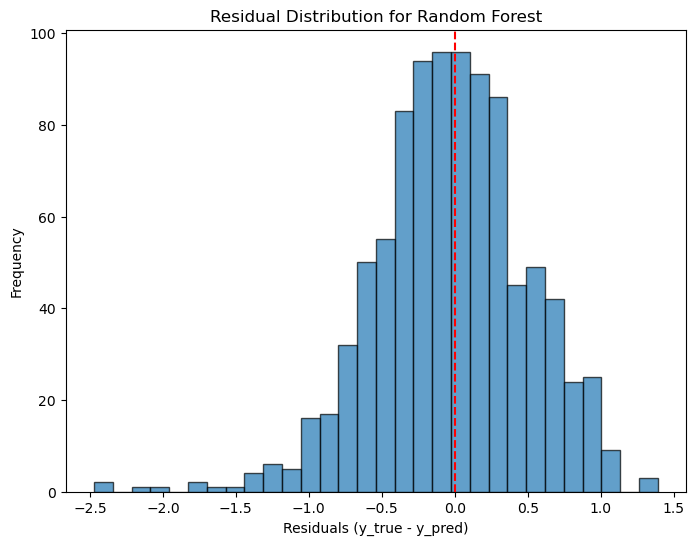

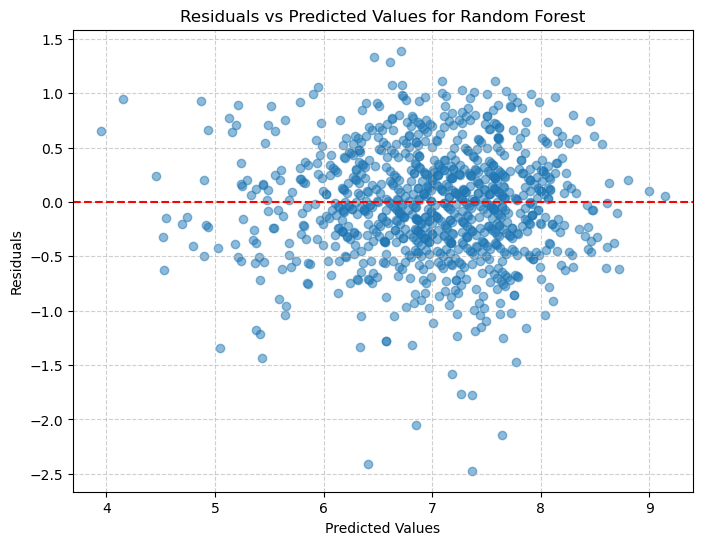

In [124]:


# 残差计算
residuals = y_test - y_test_pred

# 残差分布图
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=1.5)
plt.title(f"Residual Distribution for {'Random Forest'}")
plt.xlabel("Residuals (y_true - y_pred)")
plt.ylabel("Frequency")
plt.savefig("Residual Distribution for Random Forest.png", dpi=300, bbox_inches="tight")

plt.show()

# 残差散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title(f"Residuals vs Predicted Values for {'Random Forest'}")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("Residuals vs Predicted Values for Random Forest.png", dpi=300, bbox_inches="tight")

plt.show()


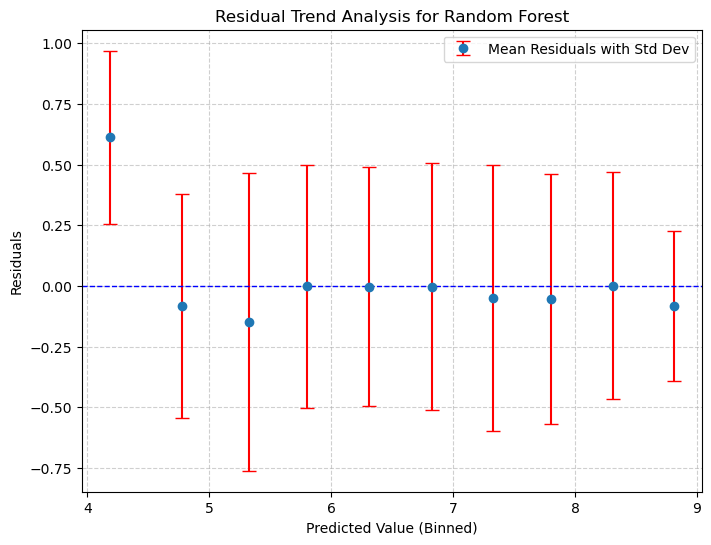

In [125]:
import pandas as pd

# 分箱统计残差
bins = pd.cut(y_test_pred, bins=10)  # 将预测值分成10个区间
residuals_df = pd.DataFrame({'Predicted': y_test_pred, 'Residuals': residuals})
binned = residuals_df.groupby(bins).agg(['mean', 'std']).reset_index()

# 绘制残差趋势图
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=binned['Predicted']['mean'], 
    y=binned['Residuals']['mean'], 
    yerr=binned['Residuals']['std'], 
    fmt='o', ecolor='red', capsize=5, label="Mean Residuals with Std Dev"
)
plt.axhline(0, color='blue', linestyle='--', linewidth=1)
plt.title(f"Residual Trend Analysis for {'Random Forest'}")
plt.xlabel("Predicted Value (Binned)")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("Residual Trend Analysis for Random Forest.png", dpi=300, bbox_inches="tight")

plt.show()


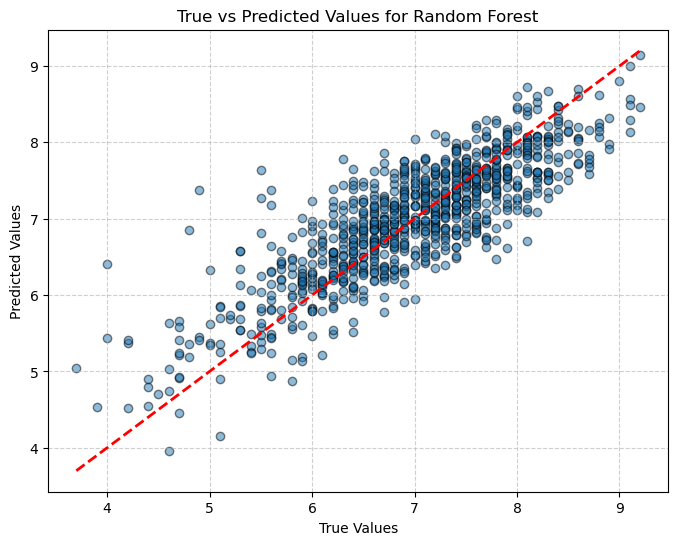

In [126]:
# 预测值 vs 真实值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title(f"True vs Predicted Values for {'Random Forest'}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("True vs Predicted Values for Random Forest.png", dpi=300, bbox_inches="tight")
plt.show()


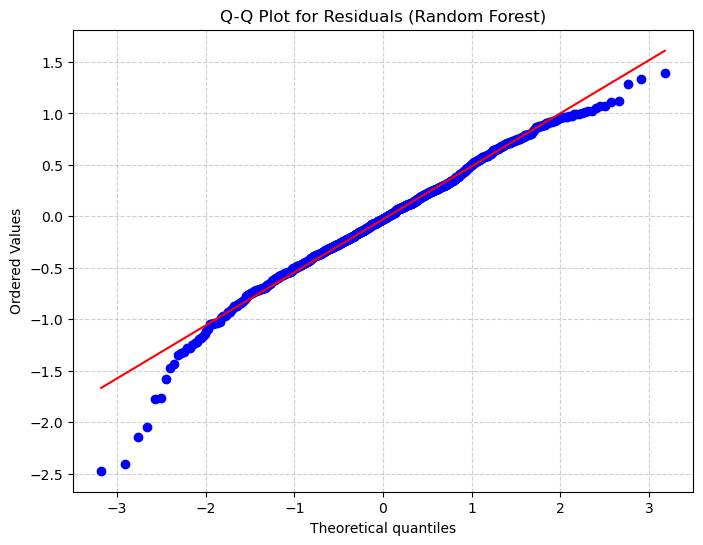

In [127]:
import scipy.stats as stats

# 绘制 Q-Q 图
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"Q-Q Plot for Residuals ({'Random Forest'})")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("Q-Q Plot for Residuals.png", dpi=300, bbox_inches="tight")
plt.show()


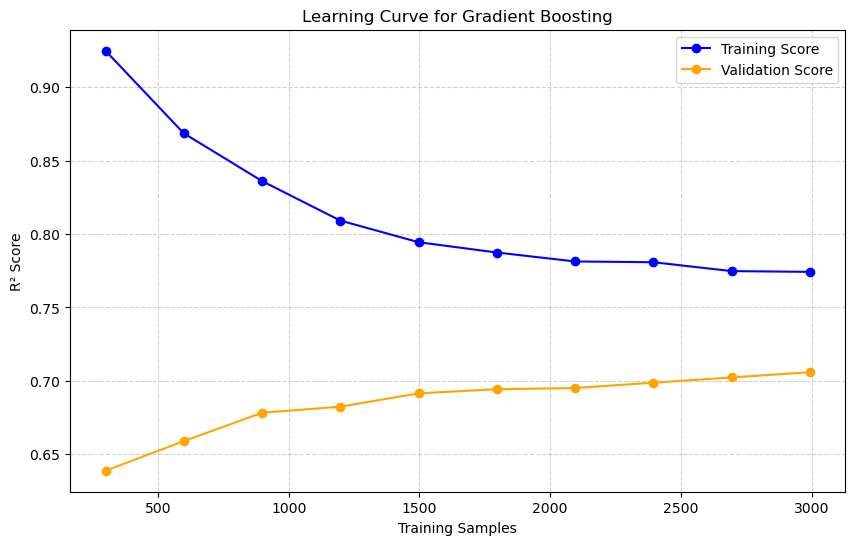

In [121]:
from sklearn.model_selection import learning_curve

# 绘制学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model, X=X_train, y=y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

# 计算均值和标准差
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Validation Score')
plt.title(f"Learning Curve for {best_model_name}")
plt.xlabel("Training Samples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
